In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/395 [..............................] - ETA: 8:51 - loss: 2.2680 - STD: 0.0613 - MAE: 0.2194


  5/395 [..............................] - ETA: 5s - loss: 2.1182 - STD: 0.0530 - MAE: 0.2166  


  9/395 [..............................] - ETA: 5s - loss: 2.1008 - STD: 0.0459 - MAE: 0.2169


 13/395 [..............................] - ETA: 5s - loss: 2.0859 - STD: 0.0423 - MAE: 0.2168


 17/395 [>.............................] - ETA: 5s - loss: 2.0783 - STD: 0.0414 - MAE: 0.2167


 21/395 [>.............................] - ETA: 5s - loss: 2.0715 - STD: 0.0402 - MAE: 0.2166


 25/395 [>.............................] - ETA: 5s - loss: 2.0649 - STD: 0.0395 - MAE: 0.2164


 29/395 [=>............................] - ETA: 5s - loss: 2.0579 - STD: 0.0386 - MAE: 0.2163


 33/395 [=>............................] - ETA: 5s - loss: 2.0488 - STD: 0.0392 - MAE: 0.2159


 37/395 [=>............................] - ETA: 5s - loss: 2.0384 - STD: 0.0403 - MAE: 0.2155


 41/395 [==>...........................] - ETA: 5s - loss: 2.0275 - STD: 0.0425 - MAE: 0.2149


 44/395 [==>...........................] - ETA: 5s - loss: 2.0185 - STD: 0.0442 - MAE: 0.2144


 48/395 [==>...........................] - ETA: 5s - loss: 2.0069 - STD: 0.0464 - MAE: 0.2138


 52/395 [==>...........................] - ETA: 5s - loss: 1.9954 - STD: 0.0486 - MAE: 0.2132


 56/395 [===>..........................] - ETA: 5s - loss: 1.9842 - STD: 0.0508 - MAE: 0.2126


 60/395 [===>..........................] - ETA: 5s - loss: 1.9730 - STD: 0.0529 - MAE: 0.2120


 64/395 [===>..........................] - ETA: 5s - loss: 1.9615 - STD: 0.0550 - MAE: 0.2114


 68/395 [====>.........................] - ETA: 4s - loss: 1.9499 - STD: 0.0570 - MAE: 0.2108


 72/395 [====>.........................] - ETA: 4s - loss: 1.9381 - STD: 0.0590 - MAE: 0.2101


 76/395 [====>.........................] - ETA: 4s - loss: 1.9261 - STD: 0.0610 - MAE: 0.2094


 80/395 [=====>........................] - ETA: 4s - loss: 1.9134 - STD: 0.0629 - MAE: 0.2087


 84/395 [=====>........................] - ETA: 4s - loss: 1.8997 - STD: 0.0649 - MAE: 0.2080


 88/395 [=====>........................] - ETA: 4s - loss: 1.8849 - STD: 0.0669 - MAE: 0.2072


 92/395 [=====>........................] - ETA: 4s - loss: 1.8693 - STD: 0.0689 - MAE: 0.2063


 96/395 [======>.......................] - ETA: 4s - loss: 1.8530 - STD: 0.0712 - MAE: 0.2053


100/395 [======>.......................] - ETA: 4s - loss: 1.8371 - STD: 0.0735 - MAE: 0.2043


104/395 [======>.......................] - ETA: 4s - loss: 1.8216 - STD: 0.0759 - MAE: 0.2033


107/395 [=======>......................] - ETA: 4s - loss: 1.8103 - STD: 0.0777 - MAE: 0.2025


111/395 [=======>......................] - ETA: 4s - loss: 1.7955 - STD: 0.0800 - MAE: 0.2015


115/395 [=======>......................] - ETA: 4s - loss: 1.7811 - STD: 0.0823 - MAE: 0.2005


119/395 [========>.....................] - ETA: 4s - loss: 1.7672 - STD: 0.0845 - MAE: 0.1996


123/395 [========>.....................] - ETA: 4s - loss: 1.7543 - STD: 0.0867 - MAE: 0.1986


127/395 [========>.....................] - ETA: 4s - loss: 1.7420 - STD: 0.0887 - MAE: 0.1977


131/395 [========>.....................] - ETA: 4s - loss: 1.7299 - STD: 0.0907 - MAE: 0.1968


135/395 [=========>....................] - ETA: 3s - loss: 1.7185 - STD: 0.0926 - MAE: 0.1960


139/395 [=========>....................] - ETA: 3s - loss: 1.7076 - STD: 0.0944 - MAE: 0.1952


143/395 [=========>....................] - ETA: 3s - loss: 1.6972 - STD: 0.0962 - MAE: 0.1944


147/395 [==========>...................] - ETA: 3s - loss: 1.6871 - STD: 0.0978 - MAE: 0.1937


151/395 [==========>...................] - ETA: 3s - loss: 1.6771 - STD: 0.0994 - MAE: 0.1929


155/395 [==========>...................] - ETA: 3s - loss: 1.6678 - STD: 0.1010 - MAE: 0.1922


159/395 [===========>..................] - ETA: 3s - loss: 1.6589 - STD: 0.1024 - MAE: 0.1916


163/395 [===========>..................] - ETA: 3s - loss: 1.6504 - STD: 0.1039 - MAE: 0.1909


167/395 [===========>..................] - ETA: 3s - loss: 1.6419 - STD: 0.1052 - MAE: 0.1903


171/395 [===========>..................] - ETA: 3s - loss: 1.6336 - STD: 0.1066 - MAE: 0.1896


175/395 [============>.................] - ETA: 3s - loss: 1.6258 - STD: 0.1079 - MAE: 0.1890


178/395 [============>.................] - ETA: 3s - loss: 1.6202 - STD: 0.1089 - MAE: 0.1886


182/395 [============>.................] - ETA: 3s - loss: 1.6128 - STD: 0.1101 - MAE: 0.1880


186/395 [=============>................] - ETA: 3s - loss: 1.6057 - STD: 0.1113 - MAE: 0.1875


190/395 [=============>................] - ETA: 3s - loss: 1.5989 - STD: 0.1124 - MAE: 0.1869


194/395 [=============>................] - ETA: 3s - loss: 1.5922 - STD: 0.1136 - MAE: 0.1864


198/395 [==============>...............] - ETA: 3s - loss: 1.5860 - STD: 0.1146 - MAE: 0.1859


202/395 [==============>...............] - ETA: 2s - loss: 1.5796 - STD: 0.1157 - MAE: 0.1854


206/395 [==============>...............] - ETA: 2s - loss: 1.5735 - STD: 0.1167 - MAE: 0.1849


210/395 [==============>...............] - ETA: 2s - loss: 1.5674 - STD: 0.1177 - MAE: 0.1844


214/395 [===============>..............] - ETA: 2s - loss: 1.5616 - STD: 0.1186 - MAE: 0.1840


218/395 [===============>..............] - ETA: 2s - loss: 1.5558 - STD: 0.1196 - MAE: 0.1835


221/395 [===============>..............] - ETA: 2s - loss: 1.5515 - STD: 0.1203 - MAE: 0.1832


225/395 [================>.............] - ETA: 2s - loss: 1.5460 - STD: 0.1212 - MAE: 0.1827


229/395 [================>.............] - ETA: 2s - loss: 1.5406 - STD: 0.1221 - MAE: 0.1823


233/395 [================>.............] - ETA: 2s - loss: 1.5355 - STD: 0.1229 - MAE: 0.1819


237/395 [=================>............] - ETA: 2s - loss: 1.5303 - STD: 0.1238 - MAE: 0.1815


241/395 [=================>............] - ETA: 2s - loss: 1.5253 - STD: 0.1246 - MAE: 0.1810


244/395 [=================>............] - ETA: 2s - loss: 1.5217 - STD: 0.1252 - MAE: 0.1807


248/395 [=================>............] - ETA: 2s - loss: 1.5170 - STD: 0.1260 - MAE: 0.1804


252/395 [==================>...........] - ETA: 2s - loss: 1.5127 - STD: 0.1268 - MAE: 0.1800


255/395 [==================>...........] - ETA: 2s - loss: 1.5093 - STD: 0.1273 - MAE: 0.1797


259/395 [==================>...........] - ETA: 2s - loss: 1.5048 - STD: 0.1281 - MAE: 0.1793


263/395 [==================>...........] - ETA: 2s - loss: 1.5002 - STD: 0.1288 - MAE: 0.1789


266/395 [===================>..........] - ETA: 2s - loss: 1.4970 - STD: 0.1293 - MAE: 0.1786


270/395 [===================>..........] - ETA: 2s - loss: 1.4927 - STD: 0.1300 - MAE: 0.1783


274/395 [===================>..........] - ETA: 2s - loss: 1.4885 - STD: 0.1307 - MAE: 0.1779


277/395 [====================>.........] - ETA: 2s - loss: 1.4853 - STD: 0.1312 - MAE: 0.1777


280/395 [====================>.........] - ETA: 2s - loss: 1.4822 - STD: 0.1318 - MAE: 0.1774


284/395 [====================>.........] - ETA: 1s - loss: 1.4782 - STD: 0.1324 - MAE: 0.1771


288/395 [====================>.........] - ETA: 1s - loss: 1.4742 - STD: 0.1331 - MAE: 0.1767


292/395 [=====================>........] - ETA: 1s - loss: 1.4702 - STD: 0.1337 - MAE: 0.1764


296/395 [=====================>........] - ETA: 1s - loss: 1.4663 - STD: 0.1343 - MAE: 0.1761


300/395 [=====================>........] - ETA: 1s - loss: 1.4624 - STD: 0.1350 - MAE: 0.1757


304/395 [======================>.......] - ETA: 1s - loss: 1.4586 - STD: 0.1356 - MAE: 0.1754


308/395 [======================>.......] - ETA: 1s - loss: 1.4549 - STD: 0.1362 - MAE: 0.1751


312/395 [======================>.......] - ETA: 1s - loss: 1.4516 - STD: 0.1368 - MAE: 0.1748


316/395 [=======================>......] - ETA: 1s - loss: 1.4481 - STD: 0.1373 - MAE: 0.1745


320/395 [=======================>......] - ETA: 1s - loss: 1.4445 - STD: 0.1379 - MAE: 0.1742


324/395 [=======================>......] - ETA: 1s - loss: 1.4411 - STD: 0.1385 - MAE: 0.1739


328/395 [=======================>......] - ETA: 1s - loss: 1.4377 - STD: 0.1390 - MAE: 0.1736


332/395 [========================>.....] - ETA: 1s - loss: 1.4345 - STD: 0.1396 - MAE: 0.1733


335/395 [========================>.....] - ETA: 1s - loss: 1.4322 - STD: 0.1399 - MAE: 0.1731


338/395 [========================>.....] - ETA: 1s - loss: 1.4297 - STD: 0.1403 - MAE: 0.1729


342/395 [========================>.....] - ETA: 0s - loss: 1.4265 - STD: 0.1409 - MAE: 0.1726


346/395 [=========================>....] - ETA: 0s - loss: 1.4233 - STD: 0.1414 - MAE: 0.1723


350/395 [=========================>....] - ETA: 0s - loss: 1.4203 - STD: 0.1419 - MAE: 0.1720


354/395 [=========================>....] - ETA: 0s - loss: 1.4173 - STD: 0.1424 - MAE: 0.1718


358/395 [==========================>...] - ETA: 0s - loss: 1.4143 - STD: 0.1428 - MAE: 0.1715


361/395 [==========================>...] - ETA: 0s - loss: 1.4120 - STD: 0.1432 - MAE: 0.1713


365/395 [==========================>...] - ETA: 0s - loss: 1.4092 - STD: 0.1437 - MAE: 0.1711


369/395 [===========================>..] - ETA: 0s - loss: 1.4066 - STD: 0.1441 - MAE: 0.1708


373/395 [===========================>..] - ETA: 0s - loss: 1.4038 - STD: 0.1446 - MAE: 0.1706


377/395 [===========================>..] - ETA: 0s - loss: 1.4011 - STD: 0.1450 - MAE: 0.1703


381/395 [===========================>..] - ETA: 0s - loss: 1.3983 - STD: 0.1455 - MAE: 0.1701


384/395 [============================>.] - ETA: 0s - loss: 1.3962 - STD: 0.1458 - MAE: 0.1699


388/395 [============================>.] - ETA: 0s - loss: 1.3935 - STD: 0.1462 - MAE: 0.1697


392/395 [============================>.] - ETA: 0s - loss: 1.3909 - STD: 0.1466 - MAE: 0.1694


395/395 [==============================] - 9s 20ms/step - loss: 1.3889 - STD: 0.1469 - MAE: 0.1693 - val_loss: 1.2356 - val_STD: 0.1903 - val_MAE: 0.1482


Epoch 2/10000



  1/395 [..............................] - ETA: 16s - loss: 1.1129 - STD: 0.1879 - MAE: 0.1448


  4/395 [..............................] - ETA: 6s - loss: 1.1239 - STD: 0.1875 - MAE: 0.1460 


  8/395 [..............................] - ETA: 6s - loss: 1.1297 - STD: 0.1878 - MAE: 0.1463


 12/395 [..............................] - ETA: 6s - loss: 1.1270 - STD: 0.1881 - MAE: 0.1460


 16/395 [>.............................] - ETA: 6s - loss: 1.1262 - STD: 0.1884 - MAE: 0.1459


 20/395 [>.............................] - ETA: 5s - loss: 1.1243 - STD: 0.1889 - MAE: 0.1456


 24/395 [>.............................] - ETA: 5s - loss: 1.1228 - STD: 0.1890 - MAE: 0.1454


 27/395 [=>............................] - ETA: 5s - loss: 1.1234 - STD: 0.1891 - MAE: 0.1454


 30/395 [=>............................] - ETA: 5s - loss: 1.1228 - STD: 0.1891 - MAE: 0.1454


 34/395 [=>............................] - ETA: 5s - loss: 1.1236 - STD: 0.1892 - MAE: 0.1454


 38/395 [=>............................] - ETA: 5s - loss: 1.1233 - STD: 0.1893 - MAE: 0.1453


 42/395 [==>...........................] - ETA: 5s - loss: 1.1229 - STD: 0.1894 - MAE: 0.1453


 46/395 [==>...........................] - ETA: 5s - loss: 1.1219 - STD: 0.1895 - MAE: 0.1452


 49/395 [==>...........................] - ETA: 5s - loss: 1.1223 - STD: 0.1896 - MAE: 0.1452


 52/395 [==>...........................] - ETA: 5s - loss: 1.1217 - STD: 0.1897 - MAE: 0.1451


 55/395 [===>..........................] - ETA: 5s - loss: 1.1215 - STD: 0.1898 - MAE: 0.1451


 59/395 [===>..........................] - ETA: 5s - loss: 1.1210 - STD: 0.1898 - MAE: 0.1450


 63/395 [===>..........................] - ETA: 5s - loss: 1.1200 - STD: 0.1898 - MAE: 0.1450


 67/395 [====>.........................] - ETA: 5s - loss: 1.1189 - STD: 0.1899 - MAE: 0.1449


 71/395 [====>.........................] - ETA: 5s - loss: 1.1179 - STD: 0.1901 - MAE: 0.1448


 74/395 [====>.........................] - ETA: 5s - loss: 1.1170 - STD: 0.1901 - MAE: 0.1447


 78/395 [====>.........................] - ETA: 5s - loss: 1.1158 - STD: 0.1902 - MAE: 0.1446


 82/395 [=====>........................] - ETA: 4s - loss: 1.1150 - STD: 0.1904 - MAE: 0.1445


 86/395 [=====>........................] - ETA: 4s - loss: 1.1139 - STD: 0.1905 - MAE: 0.1444


 90/395 [=====>........................] - ETA: 4s - loss: 1.1136 - STD: 0.1906 - MAE: 0.1444


 93/395 [======>.......................] - ETA: 4s - loss: 1.1128 - STD: 0.1907 - MAE: 0.1443


 97/395 [======>.......................] - ETA: 4s - loss: 1.1119 - STD: 0.1908 - MAE: 0.1442


101/395 [======>.......................] - ETA: 4s - loss: 1.1116 - STD: 0.1909 - MAE: 0.1441


105/395 [======>.......................] - ETA: 4s - loss: 1.1110 - STD: 0.1910 - MAE: 0.1440


109/395 [=======>......................] - ETA: 4s - loss: 1.1102 - STD: 0.1911 - MAE: 0.1440


112/395 [=======>......................] - ETA: 4s - loss: 1.1096 - STD: 0.1912 - MAE: 0.1439


116/395 [=======>......................] - ETA: 4s - loss: 1.1089 - STD: 0.1913 - MAE: 0.1438


120/395 [========>.....................] - ETA: 4s - loss: 1.1080 - STD: 0.1914 - MAE: 0.1437


124/395 [========>.....................] - ETA: 4s - loss: 1.1071 - STD: 0.1915 - MAE: 0.1437


128/395 [========>.....................] - ETA: 4s - loss: 1.1062 - STD: 0.1916 - MAE: 0.1436


132/395 [=========>....................] - ETA: 4s - loss: 1.1058 - STD: 0.1917 - MAE: 0.1435


135/395 [=========>....................] - ETA: 4s - loss: 1.1053 - STD: 0.1918 - MAE: 0.1434


139/395 [=========>....................] - ETA: 4s - loss: 1.1045 - STD: 0.1919 - MAE: 0.1434


143/395 [=========>....................] - ETA: 4s - loss: 1.1038 - STD: 0.1920 - MAE: 0.1433


146/395 [==========>...................] - ETA: 3s - loss: 1.1033 - STD: 0.1921 - MAE: 0.1432


150/395 [==========>...................] - ETA: 3s - loss: 1.1029 - STD: 0.1922 - MAE: 0.1432


154/395 [==========>...................] - ETA: 3s - loss: 1.1022 - STD: 0.1923 - MAE: 0.1431


158/395 [===========>..................] - ETA: 3s - loss: 1.1016 - STD: 0.1924 - MAE: 0.1430


161/395 [===========>..................] - ETA: 3s - loss: 1.1015 - STD: 0.1924 - MAE: 0.1430


165/395 [===========>..................] - ETA: 3s - loss: 1.1012 - STD: 0.1925 - MAE: 0.1429


169/395 [===========>..................] - ETA: 3s - loss: 1.1005 - STD: 0.1926 - MAE: 0.1429


173/395 [============>.................] - ETA: 3s - loss: 1.1001 - STD: 0.1927 - MAE: 0.1428


177/395 [============>.................] - ETA: 3s - loss: 1.0993 - STD: 0.1928 - MAE: 0.1427


180/395 [============>.................] - ETA: 3s - loss: 1.0989 - STD: 0.1929 - MAE: 0.1427


184/395 [============>.................] - ETA: 3s - loss: 1.0985 - STD: 0.1930 - MAE: 0.1426


188/395 [=============>................] - ETA: 3s - loss: 1.0979 - STD: 0.1930 - MAE: 0.1426


192/395 [=============>................] - ETA: 3s - loss: 1.0970 - STD: 0.1931 - MAE: 0.1425


196/395 [=============>................] - ETA: 3s - loss: 1.0962 - STD: 0.1932 - MAE: 0.1424


200/395 [==============>...............] - ETA: 3s - loss: 1.0953 - STD: 0.1933 - MAE: 0.1423


204/395 [==============>...............] - ETA: 3s - loss: 1.0945 - STD: 0.1934 - MAE: 0.1423


208/395 [==============>...............] - ETA: 2s - loss: 1.0938 - STD: 0.1935 - MAE: 0.1422


212/395 [===============>..............] - ETA: 2s - loss: 1.0929 - STD: 0.1935 - MAE: 0.1421


216/395 [===============>..............] - ETA: 2s - loss: 1.0919 - STD: 0.1937 - MAE: 0.1420


220/395 [===============>..............] - ETA: 2s - loss: 1.0909 - STD: 0.1938 - MAE: 0.1419


223/395 [===============>..............] - ETA: 2s - loss: 1.0903 - STD: 0.1939 - MAE: 0.1418


227/395 [================>.............] - ETA: 2s - loss: 1.0896 - STD: 0.1940 - MAE: 0.1417


231/395 [================>.............] - ETA: 2s - loss: 1.0888 - STD: 0.1941 - MAE: 0.1416


235/395 [================>.............] - ETA: 2s - loss: 1.0882 - STD: 0.1942 - MAE: 0.1416


239/395 [=================>............] - ETA: 2s - loss: 1.0879 - STD: 0.1943 - MAE: 0.1415


243/395 [=================>............] - ETA: 2s - loss: 1.0872 - STD: 0.1944 - MAE: 0.1414


246/395 [=================>............] - ETA: 2s - loss: 1.0868 - STD: 0.1945 - MAE: 0.1414


250/395 [=================>............] - ETA: 2s - loss: 1.0863 - STD: 0.1946 - MAE: 0.1413


254/395 [==================>...........] - ETA: 2s - loss: 1.0857 - STD: 0.1947 - MAE: 0.1412


258/395 [==================>...........] - ETA: 2s - loss: 1.0850 - STD: 0.1948 - MAE: 0.1412


262/395 [==================>...........] - ETA: 2s - loss: 1.0846 - STD: 0.1949 - MAE: 0.1411


266/395 [===================>..........] - ETA: 2s - loss: 1.0840 - STD: 0.1950 - MAE: 0.1410


270/395 [===================>..........] - ETA: 1s - loss: 1.0834 - STD: 0.1951 - MAE: 0.1410


274/395 [===================>..........] - ETA: 1s - loss: 1.0828 - STD: 0.1952 - MAE: 0.1409


278/395 [====================>.........] - ETA: 1s - loss: 1.0821 - STD: 0.1952 - MAE: 0.1408


282/395 [====================>.........] - ETA: 1s - loss: 1.0813 - STD: 0.1953 - MAE: 0.1407


286/395 [====================>.........] - ETA: 1s - loss: 1.0806 - STD: 0.1954 - MAE: 0.1407


290/395 [=====================>........] - ETA: 1s - loss: 1.0799 - STD: 0.1955 - MAE: 0.1406


294/395 [=====================>........] - ETA: 1s - loss: 1.0791 - STD: 0.1956 - MAE: 0.1405


298/395 [=====================>........] - ETA: 1s - loss: 1.0784 - STD: 0.1957 - MAE: 0.1404


302/395 [=====================>........] - ETA: 1s - loss: 1.0778 - STD: 0.1958 - MAE: 0.1404


306/395 [======================>.......] - ETA: 1s - loss: 1.0770 - STD: 0.1959 - MAE: 0.1403


309/395 [======================>.......] - ETA: 1s - loss: 1.0764 - STD: 0.1960 - MAE: 0.1402


313/395 [======================>.......] - ETA: 1s - loss: 1.0756 - STD: 0.1961 - MAE: 0.1401


317/395 [=======================>......] - ETA: 1s - loss: 1.0748 - STD: 0.1962 - MAE: 0.1401


321/395 [=======================>......] - ETA: 1s - loss: 1.0740 - STD: 0.1963 - MAE: 0.1400


325/395 [=======================>......] - ETA: 1s - loss: 1.0734 - STD: 0.1964 - MAE: 0.1399


329/395 [=======================>......] - ETA: 1s - loss: 1.0729 - STD: 0.1965 - MAE: 0.1398


333/395 [========================>.....] - ETA: 0s - loss: 1.0725 - STD: 0.1966 - MAE: 0.1398


337/395 [========================>.....] - ETA: 0s - loss: 1.0720 - STD: 0.1966 - MAE: 0.1397


341/395 [========================>.....] - ETA: 0s - loss: 1.0713 - STD: 0.1967 - MAE: 0.1396


345/395 [=========================>....] - ETA: 0s - loss: 1.0705 - STD: 0.1968 - MAE: 0.1395


349/395 [=========================>....] - ETA: 0s - loss: 1.0698 - STD: 0.1969 - MAE: 0.1395


352/395 [=========================>....] - ETA: 0s - loss: 1.0694 - STD: 0.1970 - MAE: 0.1394


356/395 [==========================>...] - ETA: 0s - loss: 1.0688 - STD: 0.1971 - MAE: 0.1393


360/395 [==========================>...] - ETA: 0s - loss: 1.0684 - STD: 0.1972 - MAE: 0.1393


364/395 [==========================>...] - ETA: 0s - loss: 1.0678 - STD: 0.1973 - MAE: 0.1392


368/395 [==========================>...] - ETA: 0s - loss: 1.0673 - STD: 0.1973 - MAE: 0.1392


372/395 [===========================>..] - ETA: 0s - loss: 1.0667 - STD: 0.1974 - MAE: 0.1391


375/395 [===========================>..] - ETA: 0s - loss: 1.0663 - STD: 0.1975 - MAE: 0.1390


379/395 [===========================>..] - ETA: 0s - loss: 1.0656 - STD: 0.1976 - MAE: 0.1390


383/395 [============================>.] - ETA: 0s - loss: 1.0650 - STD: 0.1977 - MAE: 0.1389


387/395 [============================>.] - ETA: 0s - loss: 1.0644 - STD: 0.1978 - MAE: 0.1388


391/395 [============================>.] - ETA: 0s - loss: 1.0639 - STD: 0.1978 - MAE: 0.1388


395/395 [==============================] - ETA: 0s - loss: 1.0633 - STD: 0.1979 - MAE: 0.1387


395/395 [==============================] - 7s 18ms/step - loss: 1.0633 - STD: 0.1979 - MAE: 0.1387 - val_loss: 1.1710 - val_STD: 0.2067 - val_MAE: 0.1378


Epoch 3/10000



  1/395 [..............................] - ETA: 18s - loss: 0.9913 - STD: 0.2068 - MAE: 0.1309


  4/395 [..............................] - ETA: 6s - loss: 1.0087 - STD: 0.2069 - MAE: 0.1320 


  8/395 [..............................] - ETA: 6s - loss: 1.0132 - STD: 0.2070 - MAE: 0.1322


 12/395 [..............................] - ETA: 6s - loss: 1.0141 - STD: 0.2070 - MAE: 0.1322


 16/395 [>.............................] - ETA: 6s - loss: 1.0122 - STD: 0.2069 - MAE: 0.1322


 20/395 [>.............................] - ETA: 6s - loss: 1.0137 - STD: 0.2069 - MAE: 0.1323


 24/395 [>.............................] - ETA: 5s - loss: 1.0150 - STD: 0.2069 - MAE: 0.1324


 28/395 [=>............................] - ETA: 5s - loss: 1.0148 - STD: 0.2067 - MAE: 0.1325


 32/395 [=>............................] - ETA: 5s - loss: 1.0127 - STD: 0.2066 - MAE: 0.1324


 36/395 [=>............................] - ETA: 5s - loss: 1.0115 - STD: 0.2066 - MAE: 0.1323


 40/395 [==>...........................] - ETA: 5s - loss: 1.0117 - STD: 0.2066 - MAE: 0.1324


 44/395 [==>...........................] - ETA: 5s - loss: 1.0107 - STD: 0.2066 - MAE: 0.1323


 48/395 [==>...........................] - ETA: 5s - loss: 1.0096 - STD: 0.2067 - MAE: 0.1321


 52/395 [==>...........................] - ETA: 5s - loss: 1.0085 - STD: 0.2068 - MAE: 0.1320


 56/395 [===>..........................] - ETA: 5s - loss: 1.0077 - STD: 0.2069 - MAE: 0.1320


 59/395 [===>..........................] - ETA: 5s - loss: 1.0066 - STD: 0.2069 - MAE: 0.1319


 63/395 [===>..........................] - ETA: 5s - loss: 1.0059 - STD: 0.2070 - MAE: 0.1318


 67/395 [====>.........................] - ETA: 5s - loss: 1.0054 - STD: 0.2071 - MAE: 0.1317


 71/395 [====>.........................] - ETA: 5s - loss: 1.0048 - STD: 0.2072 - MAE: 0.1317


 75/395 [====>.........................] - ETA: 5s - loss: 1.0046 - STD: 0.2073 - MAE: 0.1316


 79/395 [=====>........................] - ETA: 4s - loss: 1.0045 - STD: 0.2073 - MAE: 0.1316


 83/395 [=====>........................] - ETA: 4s - loss: 1.0047 - STD: 0.2074 - MAE: 0.1316


 87/395 [=====>........................] - ETA: 4s - loss: 1.0048 - STD: 0.2074 - MAE: 0.1316


 91/395 [=====>........................] - ETA: 4s - loss: 1.0042 - STD: 0.2075 - MAE: 0.1315


 95/395 [======>.......................] - ETA: 4s - loss: 1.0039 - STD: 0.2075 - MAE: 0.1315


 99/395 [======>.......................] - ETA: 4s - loss: 1.0033 - STD: 0.2075 - MAE: 0.1315


103/395 [======>.......................] - ETA: 4s - loss: 1.0024 - STD: 0.2076 - MAE: 0.1314


106/395 [=======>......................] - ETA: 4s - loss: 1.0021 - STD: 0.2076 - MAE: 0.1314


109/395 [=======>......................] - ETA: 4s - loss: 1.0020 - STD: 0.2076 - MAE: 0.1313


112/395 [=======>......................] - ETA: 4s - loss: 1.0020 - STD: 0.2077 - MAE: 0.1313


116/395 [=======>......................] - ETA: 4s - loss: 1.0020 - STD: 0.2078 - MAE: 0.1313


120/395 [========>.....................] - ETA: 4s - loss: 1.0018 - STD: 0.2078 - MAE: 0.1312


124/395 [========>.....................] - ETA: 4s - loss: 1.0021 - STD: 0.2079 - MAE: 0.1312


128/395 [========>.....................] - ETA: 4s - loss: 1.0019 - STD: 0.2079 - MAE: 0.1312


131/395 [========>.....................] - ETA: 4s - loss: 1.0018 - STD: 0.2080 - MAE: 0.1312


135/395 [=========>....................] - ETA: 4s - loss: 1.0017 - STD: 0.2080 - MAE: 0.1312


139/395 [=========>....................] - ETA: 4s - loss: 1.0010 - STD: 0.2080 - MAE: 0.1311


143/395 [=========>....................] - ETA: 3s - loss: 1.0008 - STD: 0.2080 - MAE: 0.1311


147/395 [==========>...................] - ETA: 3s - loss: 0.9999 - STD: 0.2081 - MAE: 0.1310


150/395 [==========>...................] - ETA: 3s - loss: 0.9994 - STD: 0.2081 - MAE: 0.1310


154/395 [==========>...................] - ETA: 3s - loss: 0.9987 - STD: 0.2082 - MAE: 0.1309


158/395 [===========>..................] - ETA: 3s - loss: 0.9982 - STD: 0.2082 - MAE: 0.1309


162/395 [===========>..................] - ETA: 3s - loss: 0.9976 - STD: 0.2083 - MAE: 0.1308


166/395 [===========>..................] - ETA: 3s - loss: 0.9970 - STD: 0.2083 - MAE: 0.1308


169/395 [===========>..................] - ETA: 3s - loss: 0.9965 - STD: 0.2083 - MAE: 0.1307


172/395 [============>.................] - ETA: 3s - loss: 0.9960 - STD: 0.2084 - MAE: 0.1307


176/395 [============>.................] - ETA: 3s - loss: 0.9957 - STD: 0.2084 - MAE: 0.1306


180/395 [============>.................] - ETA: 3s - loss: 0.9950 - STD: 0.2085 - MAE: 0.1306


184/395 [============>.................] - ETA: 3s - loss: 0.9945 - STD: 0.2086 - MAE: 0.1305


188/395 [=============>................] - ETA: 3s - loss: 0.9940 - STD: 0.2086 - MAE: 0.1305


191/395 [=============>................] - ETA: 3s - loss: 0.9935 - STD: 0.2087 - MAE: 0.1304


194/395 [=============>................] - ETA: 3s - loss: 0.9935 - STD: 0.2087 - MAE: 0.1304


198/395 [==============>...............] - ETA: 3s - loss: 0.9931 - STD: 0.2088 - MAE: 0.1303


202/395 [==============>...............] - ETA: 3s - loss: 0.9929 - STD: 0.2089 - MAE: 0.1303


206/395 [==============>...............] - ETA: 2s - loss: 0.9926 - STD: 0.2089 - MAE: 0.1302


210/395 [==============>...............] - ETA: 2s - loss: 0.9921 - STD: 0.2090 - MAE: 0.1302


213/395 [===============>..............] - ETA: 2s - loss: 0.9918 - STD: 0.2090 - MAE: 0.1302


217/395 [===============>..............] - ETA: 2s - loss: 0.9913 - STD: 0.2091 - MAE: 0.1301


221/395 [===============>..............] - ETA: 2s - loss: 0.9908 - STD: 0.2091 - MAE: 0.1301


225/395 [================>.............] - ETA: 2s - loss: 0.9903 - STD: 0.2092 - MAE: 0.1300


229/395 [================>.............] - ETA: 2s - loss: 0.9900 - STD: 0.2093 - MAE: 0.1299


232/395 [================>.............] - ETA: 2s - loss: 0.9899 - STD: 0.2093 - MAE: 0.1299


235/395 [================>.............] - ETA: 2s - loss: 0.9896 - STD: 0.2093 - MAE: 0.1299


239/395 [=================>............] - ETA: 2s - loss: 0.9895 - STD: 0.2094 - MAE: 0.1299


243/395 [=================>............] - ETA: 2s - loss: 0.9891 - STD: 0.2094 - MAE: 0.1298


247/395 [=================>............] - ETA: 2s - loss: 0.9890 - STD: 0.2095 - MAE: 0.1298


251/395 [==================>...........] - ETA: 2s - loss: 0.9891 - STD: 0.2095 - MAE: 0.1298


254/395 [==================>...........] - ETA: 2s - loss: 0.9889 - STD: 0.2095 - MAE: 0.1298


258/395 [==================>...........] - ETA: 2s - loss: 0.9887 - STD: 0.2096 - MAE: 0.1297


262/395 [==================>...........] - ETA: 2s - loss: 0.9883 - STD: 0.2096 - MAE: 0.1297


266/395 [===================>..........] - ETA: 2s - loss: 0.9878 - STD: 0.2097 - MAE: 0.1297


270/395 [===================>..........] - ETA: 1s - loss: 0.9875 - STD: 0.2097 - MAE: 0.1296


273/395 [===================>..........] - ETA: 1s - loss: 0.9871 - STD: 0.2097 - MAE: 0.1296


277/395 [====================>.........] - ETA: 1s - loss: 0.9867 - STD: 0.2098 - MAE: 0.1295


281/395 [====================>.........] - ETA: 1s - loss: 0.9863 - STD: 0.2098 - MAE: 0.1295


285/395 [====================>.........] - ETA: 1s - loss: 0.9860 - STD: 0.2099 - MAE: 0.1295


288/395 [====================>.........] - ETA: 1s - loss: 0.9857 - STD: 0.2099 - MAE: 0.1294


292/395 [=====================>........] - ETA: 1s - loss: 0.9856 - STD: 0.2099 - MAE: 0.1294


295/395 [=====================>........] - ETA: 1s - loss: 0.9854 - STD: 0.2100 - MAE: 0.1294


299/395 [=====================>........] - ETA: 1s - loss: 0.9850 - STD: 0.2100 - MAE: 0.1293


302/395 [=====================>........] - ETA: 1s - loss: 0.9848 - STD: 0.2100 - MAE: 0.1293


306/395 [======================>.......] - ETA: 1s - loss: 0.9848 - STD: 0.2101 - MAE: 0.1293


310/395 [======================>.......] - ETA: 1s - loss: 0.9847 - STD: 0.2101 - MAE: 0.1293


313/395 [======================>.......] - ETA: 1s - loss: 0.9847 - STD: 0.2102 - MAE: 0.1293


317/395 [=======================>......] - ETA: 1s - loss: 0.9849 - STD: 0.2102 - MAE: 0.1292


321/395 [=======================>......] - ETA: 1s - loss: 0.9848 - STD: 0.2103 - MAE: 0.1292


324/395 [=======================>......] - ETA: 1s - loss: 0.9848 - STD: 0.2103 - MAE: 0.1292


328/395 [=======================>......] - ETA: 1s - loss: 0.9848 - STD: 0.2103 - MAE: 0.1292


332/395 [========================>.....] - ETA: 1s - loss: 0.9846 - STD: 0.2104 - MAE: 0.1292


336/395 [========================>.....] - ETA: 0s - loss: 0.9843 - STD: 0.2104 - MAE: 0.1292


340/395 [========================>.....] - ETA: 0s - loss: 0.9840 - STD: 0.2104 - MAE: 0.1291


344/395 [=========================>....] - ETA: 0s - loss: 0.9837 - STD: 0.2104 - MAE: 0.1291


348/395 [=========================>....] - ETA: 0s - loss: 0.9835 - STD: 0.2104 - MAE: 0.1291


352/395 [=========================>....] - ETA: 0s - loss: 0.9833 - STD: 0.2105 - MAE: 0.1290


355/395 [=========================>....] - ETA: 0s - loss: 0.9832 - STD: 0.2105 - MAE: 0.1290


359/395 [==========================>...] - ETA: 0s - loss: 0.9830 - STD: 0.2105 - MAE: 0.1290


363/395 [==========================>...] - ETA: 0s - loss: 0.9827 - STD: 0.2106 - MAE: 0.1290


367/395 [==========================>...] - ETA: 0s - loss: 0.9823 - STD: 0.2106 - MAE: 0.1289


371/395 [===========================>..] - ETA: 0s - loss: 0.9820 - STD: 0.2106 - MAE: 0.1289


374/395 [===========================>..] - ETA: 0s - loss: 0.9818 - STD: 0.2107 - MAE: 0.1289


378/395 [===========================>..] - ETA: 0s - loss: 0.9814 - STD: 0.2107 - MAE: 0.1288


382/395 [============================>.] - ETA: 0s - loss: 0.9810 - STD: 0.2107 - MAE: 0.1288


386/395 [============================>.] - ETA: 0s - loss: 0.9806 - STD: 0.2108 - MAE: 0.1288


390/395 [============================>.] - ETA: 0s - loss: 0.9803 - STD: 0.2108 - MAE: 0.1287


394/395 [============================>.] - ETA: 0s - loss: 0.9800 - STD: 0.2109 - MAE: 0.1287


395/395 [==============================] - 7s 18ms/step - loss: 0.9799 - STD: 0.2109 - MAE: 0.1287 - val_loss: 1.1033 - val_STD: 0.2126 - val_MAE: 0.1330


Epoch 4/10000



  1/395 [..............................] - ETA: 15s - loss: 0.9518 - STD: 0.2147 - MAE: 0.1255


  4/395 [..............................] - ETA: 6s - loss: 0.9599 - STD: 0.2150 - MAE: 0.1258 


  8/395 [..............................] - ETA: 6s - loss: 0.9593 - STD: 0.2149 - MAE: 0.1257


 12/395 [..............................] - ETA: 6s - loss: 0.9607 - STD: 0.2149 - MAE: 0.1258


 16/395 [>.............................] - ETA: 5s - loss: 0.9594 - STD: 0.2148 - MAE: 0.1258


 20/395 [>.............................] - ETA: 5s - loss: 0.9602 - STD: 0.2148 - MAE: 0.1258


 24/395 [>.............................] - ETA: 5s - loss: 0.9595 - STD: 0.2146 - MAE: 0.1259


 27/395 [=>............................] - ETA: 5s - loss: 0.9592 - STD: 0.2147 - MAE: 0.1258


 31/395 [=>............................] - ETA: 5s - loss: 0.9570 - STD: 0.2147 - MAE: 0.1257


 35/395 [=>............................] - ETA: 5s - loss: 0.9553 - STD: 0.2148 - MAE: 0.1255


 39/395 [=>............................] - ETA: 5s - loss: 0.9544 - STD: 0.2148 - MAE: 0.1255


 43/395 [==>...........................] - ETA: 5s - loss: 0.9547 - STD: 0.2148 - MAE: 0.1255


 47/395 [==>...........................] - ETA: 5s - loss: 0.9537 - STD: 0.2149 - MAE: 0.1254


 50/395 [==>...........................] - ETA: 5s - loss: 0.9532 - STD: 0.2149 - MAE: 0.1254


 54/395 [===>..........................] - ETA: 5s - loss: 0.9537 - STD: 0.2149 - MAE: 0.1254


 58/395 [===>..........................] - ETA: 5s - loss: 0.9536 - STD: 0.2150 - MAE: 0.1254


 62/395 [===>..........................] - ETA: 5s - loss: 0.9528 - STD: 0.2149 - MAE: 0.1253


 66/395 [====>.........................] - ETA: 5s - loss: 0.9520 - STD: 0.2150 - MAE: 0.1253


 70/395 [====>.........................] - ETA: 5s - loss: 0.9509 - STD: 0.2150 - MAE: 0.1252


 74/395 [====>.........................] - ETA: 5s - loss: 0.9505 - STD: 0.2151 - MAE: 0.1251


 78/395 [====>.........................] - ETA: 4s - loss: 0.9503 - STD: 0.2151 - MAE: 0.1251


 82/395 [=====>........................] - ETA: 4s - loss: 0.9494 - STD: 0.2152 - MAE: 0.1250


 86/395 [=====>........................] - ETA: 4s - loss: 0.9489 - STD: 0.2152 - MAE: 0.1250


 90/395 [=====>........................] - ETA: 4s - loss: 0.9481 - STD: 0.2153 - MAE: 0.1249


 93/395 [======>.......................] - ETA: 4s - loss: 0.9475 - STD: 0.2153 - MAE: 0.1248


 97/395 [======>.......................] - ETA: 4s - loss: 0.9471 - STD: 0.2154 - MAE: 0.1248


101/395 [======>.......................] - ETA: 4s - loss: 0.9470 - STD: 0.2155 - MAE: 0.1248


105/395 [======>.......................] - ETA: 4s - loss: 0.9467 - STD: 0.2155 - MAE: 0.1247


109/395 [=======>......................] - ETA: 4s - loss: 0.9462 - STD: 0.2155 - MAE: 0.1247


112/395 [=======>......................] - ETA: 4s - loss: 0.9457 - STD: 0.2156 - MAE: 0.1246


116/395 [=======>......................] - ETA: 4s - loss: 0.9453 - STD: 0.2156 - MAE: 0.1246


120/395 [========>.....................] - ETA: 4s - loss: 0.9448 - STD: 0.2156 - MAE: 0.1246


124/395 [========>.....................] - ETA: 4s - loss: 0.9448 - STD: 0.2157 - MAE: 0.1246


128/395 [========>.....................] - ETA: 4s - loss: 0.9447 - STD: 0.2157 - MAE: 0.1245


132/395 [=========>....................] - ETA: 4s - loss: 0.9444 - STD: 0.2158 - MAE: 0.1245


136/395 [=========>....................] - ETA: 4s - loss: 0.9439 - STD: 0.2158 - MAE: 0.1244


140/395 [=========>....................] - ETA: 4s - loss: 0.9440 - STD: 0.2158 - MAE: 0.1244


144/395 [=========>....................] - ETA: 3s - loss: 0.9439 - STD: 0.2158 - MAE: 0.1244


148/395 [==========>...................] - ETA: 3s - loss: 0.9432 - STD: 0.2159 - MAE: 0.1243


152/395 [==========>...................] - ETA: 3s - loss: 0.9427 - STD: 0.2159 - MAE: 0.1243


156/395 [==========>...................] - ETA: 3s - loss: 0.9423 - STD: 0.2159 - MAE: 0.1243


160/395 [===========>..................] - ETA: 3s - loss: 0.9420 - STD: 0.2160 - MAE: 0.1242


164/395 [===========>..................] - ETA: 3s - loss: 0.9420 - STD: 0.2160 - MAE: 0.1242


168/395 [===========>..................] - ETA: 3s - loss: 0.9419 - STD: 0.2161 - MAE: 0.1242


172/395 [============>.................] - ETA: 3s - loss: 0.9415 - STD: 0.2161 - MAE: 0.1242


176/395 [============>.................] - ETA: 3s - loss: 0.9412 - STD: 0.2161 - MAE: 0.1241


180/395 [============>.................] - ETA: 3s - loss: 0.9413 - STD: 0.2161 - MAE: 0.1241


184/395 [============>.................] - ETA: 3s - loss: 0.9409 - STD: 0.2162 - MAE: 0.1241


188/395 [=============>................] - ETA: 3s - loss: 0.9405 - STD: 0.2162 - MAE: 0.1240


192/395 [=============>................] - ETA: 3s - loss: 0.9402 - STD: 0.2163 - MAE: 0.1240


196/395 [=============>................] - ETA: 3s - loss: 0.9401 - STD: 0.2163 - MAE: 0.1240


200/395 [==============>...............] - ETA: 3s - loss: 0.9400 - STD: 0.2163 - MAE: 0.1240


204/395 [==============>...............] - ETA: 3s - loss: 0.9400 - STD: 0.2163 - MAE: 0.1240


208/395 [==============>...............] - ETA: 2s - loss: 0.9406 - STD: 0.2164 - MAE: 0.1240


212/395 [===============>..............] - ETA: 2s - loss: 0.9407 - STD: 0.2164 - MAE: 0.1240


216/395 [===============>..............] - ETA: 2s - loss: 0.9406 - STD: 0.2164 - MAE: 0.1240


220/395 [===============>..............] - ETA: 2s - loss: 0.9404 - STD: 0.2164 - MAE: 0.1240


224/395 [================>.............] - ETA: 2s - loss: 0.9405 - STD: 0.2165 - MAE: 0.1240


228/395 [================>.............] - ETA: 2s - loss: 0.9402 - STD: 0.2165 - MAE: 0.1239


232/395 [================>.............] - ETA: 2s - loss: 0.9400 - STD: 0.2165 - MAE: 0.1239


236/395 [================>.............] - ETA: 2s - loss: 0.9397 - STD: 0.2165 - MAE: 0.1239


240/395 [=================>............] - ETA: 2s - loss: 0.9393 - STD: 0.2165 - MAE: 0.1239


244/395 [=================>............] - ETA: 2s - loss: 0.9391 - STD: 0.2165 - MAE: 0.1239


248/395 [=================>............] - ETA: 2s - loss: 0.9389 - STD: 0.2166 - MAE: 0.1238


252/395 [==================>...........] - ETA: 2s - loss: 0.9387 - STD: 0.2166 - MAE: 0.1238


256/395 [==================>...........] - ETA: 2s - loss: 0.9386 - STD: 0.2166 - MAE: 0.1238


260/395 [==================>...........] - ETA: 2s - loss: 0.9384 - STD: 0.2166 - MAE: 0.1238


264/395 [===================>..........] - ETA: 2s - loss: 0.9381 - STD: 0.2167 - MAE: 0.1237


268/395 [===================>..........] - ETA: 2s - loss: 0.9380 - STD: 0.2167 - MAE: 0.1237


271/395 [===================>..........] - ETA: 1s - loss: 0.9378 - STD: 0.2167 - MAE: 0.1237


275/395 [===================>..........] - ETA: 1s - loss: 0.9376 - STD: 0.2167 - MAE: 0.1237


279/395 [====================>.........] - ETA: 1s - loss: 0.9375 - STD: 0.2168 - MAE: 0.1236


283/395 [====================>.........] - ETA: 1s - loss: 0.9371 - STD: 0.2168 - MAE: 0.1236


287/395 [====================>.........] - ETA: 1s - loss: 0.9369 - STD: 0.2168 - MAE: 0.1236


291/395 [=====================>........] - ETA: 1s - loss: 0.9367 - STD: 0.2168 - MAE: 0.1236


295/395 [=====================>........] - ETA: 1s - loss: 0.9364 - STD: 0.2169 - MAE: 0.1235


299/395 [=====================>........] - ETA: 1s - loss: 0.9362 - STD: 0.2169 - MAE: 0.1235


303/395 [======================>.......] - ETA: 1s - loss: 0.9360 - STD: 0.2169 - MAE: 0.1235


307/395 [======================>.......] - ETA: 1s - loss: 0.9358 - STD: 0.2169 - MAE: 0.1235


311/395 [======================>.......] - ETA: 1s - loss: 0.9354 - STD: 0.2170 - MAE: 0.1234


315/395 [======================>.......] - ETA: 1s - loss: 0.9352 - STD: 0.2170 - MAE: 0.1234


319/395 [=======================>......] - ETA: 1s - loss: 0.9350 - STD: 0.2170 - MAE: 0.1234


323/395 [=======================>......] - ETA: 1s - loss: 0.9350 - STD: 0.2171 - MAE: 0.1234


327/395 [=======================>......] - ETA: 1s - loss: 0.9349 - STD: 0.2171 - MAE: 0.1233


331/395 [========================>.....] - ETA: 1s - loss: 0.9350 - STD: 0.2171 - MAE: 0.1233


335/395 [========================>.....] - ETA: 0s - loss: 0.9348 - STD: 0.2172 - MAE: 0.1233


338/395 [========================>.....] - ETA: 0s - loss: 0.9347 - STD: 0.2172 - MAE: 0.1233


342/395 [========================>.....] - ETA: 0s - loss: 0.9346 - STD: 0.2172 - MAE: 0.1233


346/395 [=========================>....] - ETA: 0s - loss: 0.9345 - STD: 0.2172 - MAE: 0.1233


350/395 [=========================>....] - ETA: 0s - loss: 0.9343 - STD: 0.2173 - MAE: 0.1233


354/395 [=========================>....] - ETA: 0s - loss: 0.9342 - STD: 0.2173 - MAE: 0.1232


358/395 [==========================>...] - ETA: 0s - loss: 0.9343 - STD: 0.2173 - MAE: 0.1232


361/395 [==========================>...] - ETA: 0s - loss: 0.9344 - STD: 0.2173 - MAE: 0.1232


365/395 [==========================>...] - ETA: 0s - loss: 0.9341 - STD: 0.2173 - MAE: 0.1232


369/395 [===========================>..] - ETA: 0s - loss: 0.9339 - STD: 0.2173 - MAE: 0.1232


373/395 [===========================>..] - ETA: 0s - loss: 0.9338 - STD: 0.2174 - MAE: 0.1232


377/395 [===========================>..] - ETA: 0s - loss: 0.9334 - STD: 0.2174 - MAE: 0.1232


380/395 [===========================>..] - ETA: 0s - loss: 0.9333 - STD: 0.2174 - MAE: 0.1231


384/395 [============================>.] - ETA: 0s - loss: 0.9331 - STD: 0.2174 - MAE: 0.1231


388/395 [============================>.] - ETA: 0s - loss: 0.9334 - STD: 0.2174 - MAE: 0.1231


392/395 [============================>.] - ETA: 0s - loss: 0.9333 - STD: 0.2175 - MAE: 0.1231


395/395 [==============================] - 7s 18ms/step - loss: 0.9332 - STD: 0.2175 - MAE: 0.1231 - val_loss: 1.0765 - val_STD: 0.2167 - val_MAE: 0.1305


Epoch 5/10000



  1/395 [..............................] - ETA: 18s - loss: 0.9222 - STD: 0.2207 - MAE: 0.1214


  4/395 [..............................] - ETA: 6s - loss: 0.9086 - STD: 0.2190 - MAE: 0.1211 


  8/395 [..............................] - ETA: 6s - loss: 0.9057 - STD: 0.2190 - MAE: 0.1209


 12/395 [..............................] - ETA: 6s - loss: 0.9060 - STD: 0.2191 - MAE: 0.1208


 16/395 [>.............................] - ETA: 6s - loss: 0.9060 - STD: 0.2194 - MAE: 0.1207


 19/395 [>.............................] - ETA: 6s - loss: 0.9055 - STD: 0.2195 - MAE: 0.1206


 23/395 [>.............................] - ETA: 5s - loss: 0.9062 - STD: 0.2194 - MAE: 0.1207


 27/395 [=>............................] - ETA: 5s - loss: 0.9064 - STD: 0.2197 - MAE: 0.1205


 31/395 [=>............................] - ETA: 5s - loss: 0.9074 - STD: 0.2197 - MAE: 0.1206


 35/395 [=>............................] - ETA: 5s - loss: 0.9076 - STD: 0.2199 - MAE: 0.1205


 39/395 [=>............................] - ETA: 5s - loss: 0.9071 - STD: 0.2199 - MAE: 0.1204


 43/395 [==>...........................] - ETA: 5s - loss: 0.9094 - STD: 0.2200 - MAE: 0.1206


 47/395 [==>...........................] - ETA: 5s - loss: 0.9102 - STD: 0.2202 - MAE: 0.1205


 51/395 [==>...........................] - ETA: 5s - loss: 0.9106 - STD: 0.2202 - MAE: 0.1205


 55/395 [===>..........................] - ETA: 5s - loss: 0.9122 - STD: 0.2202 - MAE: 0.1207


 59/395 [===>..........................] - ETA: 5s - loss: 0.9120 - STD: 0.2202 - MAE: 0.1206


 63/395 [===>..........................] - ETA: 5s - loss: 0.9111 - STD: 0.2202 - MAE: 0.1206


 67/395 [====>.........................] - ETA: 5s - loss: 0.9108 - STD: 0.2202 - MAE: 0.1206


 71/395 [====>.........................] - ETA: 5s - loss: 0.9102 - STD: 0.2203 - MAE: 0.1205


 75/395 [====>.........................] - ETA: 5s - loss: 0.9099 - STD: 0.2203 - MAE: 0.1205


 79/395 [=====>........................] - ETA: 4s - loss: 0.9094 - STD: 0.2202 - MAE: 0.1205


 83/395 [=====>........................] - ETA: 4s - loss: 0.9088 - STD: 0.2202 - MAE: 0.1204


 87/395 [=====>........................] - ETA: 4s - loss: 0.9092 - STD: 0.2203 - MAE: 0.1204


 91/395 [=====>........................] - ETA: 4s - loss: 0.9088 - STD: 0.2203 - MAE: 0.1204


 95/395 [======>.......................] - ETA: 4s - loss: 0.9092 - STD: 0.2204 - MAE: 0.1204


 99/395 [======>.......................] - ETA: 4s - loss: 0.9091 - STD: 0.2204 - MAE: 0.1204


103/395 [======>.......................] - ETA: 4s - loss: 0.9098 - STD: 0.2205 - MAE: 0.1204


107/395 [=======>......................] - ETA: 4s - loss: 0.9097 - STD: 0.2205 - MAE: 0.1204


111/395 [=======>......................] - ETA: 4s - loss: 0.9099 - STD: 0.2205 - MAE: 0.1204


115/395 [=======>......................] - ETA: 4s - loss: 0.9098 - STD: 0.2206 - MAE: 0.1203


119/395 [========>.....................] - ETA: 4s - loss: 0.9099 - STD: 0.2206 - MAE: 0.1203


123/395 [========>.....................] - ETA: 4s - loss: 0.9099 - STD: 0.2206 - MAE: 0.1203


127/395 [========>.....................] - ETA: 4s - loss: 0.9097 - STD: 0.2206 - MAE: 0.1203


131/395 [========>.....................] - ETA: 4s - loss: 0.9095 - STD: 0.2206 - MAE: 0.1203


135/395 [=========>....................] - ETA: 4s - loss: 0.9092 - STD: 0.2206 - MAE: 0.1203


139/395 [=========>....................] - ETA: 4s - loss: 0.9086 - STD: 0.2206 - MAE: 0.1203


143/395 [=========>....................] - ETA: 3s - loss: 0.9086 - STD: 0.2206 - MAE: 0.1202


147/395 [==========>...................] - ETA: 3s - loss: 0.9088 - STD: 0.2207 - MAE: 0.1202


151/395 [==========>...................] - ETA: 3s - loss: 0.9087 - STD: 0.2207 - MAE: 0.1202


154/395 [==========>...................] - ETA: 3s - loss: 0.9084 - STD: 0.2207 - MAE: 0.1202


158/395 [===========>..................] - ETA: 3s - loss: 0.9082 - STD: 0.2207 - MAE: 0.1202


162/395 [===========>..................] - ETA: 3s - loss: 0.9081 - STD: 0.2207 - MAE: 0.1202


166/395 [===========>..................] - ETA: 3s - loss: 0.9080 - STD: 0.2208 - MAE: 0.1201


170/395 [===========>..................] - ETA: 3s - loss: 0.9078 - STD: 0.2208 - MAE: 0.1201


174/395 [============>.................] - ETA: 3s - loss: 0.9076 - STD: 0.2208 - MAE: 0.1201


177/395 [============>.................] - ETA: 3s - loss: 0.9073 - STD: 0.2208 - MAE: 0.1201


181/395 [============>.................] - ETA: 3s - loss: 0.9077 - STD: 0.2209 - MAE: 0.1201


185/395 [=============>................] - ETA: 3s - loss: 0.9079 - STD: 0.2209 - MAE: 0.1201


189/395 [=============>................] - ETA: 3s - loss: 0.9078 - STD: 0.2209 - MAE: 0.1201


193/395 [=============>................] - ETA: 3s - loss: 0.9076 - STD: 0.2209 - MAE: 0.1201


197/395 [=============>................] - ETA: 3s - loss: 0.9074 - STD: 0.2209 - MAE: 0.1200


201/395 [==============>...............] - ETA: 3s - loss: 0.9079 - STD: 0.2209 - MAE: 0.1200


205/395 [==============>...............] - ETA: 2s - loss: 0.9080 - STD: 0.2210 - MAE: 0.1200


209/395 [==============>...............] - ETA: 2s - loss: 0.9078 - STD: 0.2210 - MAE: 0.1200


213/395 [===============>..............] - ETA: 2s - loss: 0.9076 - STD: 0.2210 - MAE: 0.1200


217/395 [===============>..............] - ETA: 2s - loss: 0.9074 - STD: 0.2210 - MAE: 0.1200


221/395 [===============>..............] - ETA: 2s - loss: 0.9071 - STD: 0.2210 - MAE: 0.1200


225/395 [================>.............] - ETA: 2s - loss: 0.9067 - STD: 0.2210 - MAE: 0.1199


229/395 [================>.............] - ETA: 2s - loss: 0.9065 - STD: 0.2211 - MAE: 0.1199


233/395 [================>.............] - ETA: 2s - loss: 0.9061 - STD: 0.2211 - MAE: 0.1199


237/395 [=================>............] - ETA: 2s - loss: 0.9059 - STD: 0.2211 - MAE: 0.1198


240/395 [=================>............] - ETA: 2s - loss: 0.9057 - STD: 0.2211 - MAE: 0.1198


243/395 [=================>............] - ETA: 2s - loss: 0.9055 - STD: 0.2212 - MAE: 0.1198


247/395 [=================>............] - ETA: 2s - loss: 0.9053 - STD: 0.2212 - MAE: 0.1198


251/395 [==================>...........] - ETA: 2s - loss: 0.9049 - STD: 0.2212 - MAE: 0.1197


255/395 [==================>...........] - ETA: 2s - loss: 0.9046 - STD: 0.2213 - MAE: 0.1197


259/395 [==================>...........] - ETA: 2s - loss: 0.9046 - STD: 0.2213 - MAE: 0.1197


262/395 [==================>...........] - ETA: 2s - loss: 0.9043 - STD: 0.2213 - MAE: 0.1197


266/395 [===================>..........] - ETA: 2s - loss: 0.9043 - STD: 0.2213 - MAE: 0.1197


270/395 [===================>..........] - ETA: 1s - loss: 0.9041 - STD: 0.2213 - MAE: 0.1196


274/395 [===================>..........] - ETA: 1s - loss: 0.9038 - STD: 0.2214 - MAE: 0.1196


278/395 [====================>.........] - ETA: 1s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1196


282/395 [====================>.........] - ETA: 1s - loss: 0.9032 - STD: 0.2214 - MAE: 0.1195


286/395 [====================>.........] - ETA: 1s - loss: 0.9033 - STD: 0.2214 - MAE: 0.1195


290/395 [=====================>........] - ETA: 1s - loss: 0.9031 - STD: 0.2215 - MAE: 0.1195


294/395 [=====================>........] - ETA: 1s - loss: 0.9030 - STD: 0.2215 - MAE: 0.1195


298/395 [=====================>........] - ETA: 1s - loss: 0.9028 - STD: 0.2215 - MAE: 0.1195


302/395 [=====================>........] - ETA: 1s - loss: 0.9027 - STD: 0.2215 - MAE: 0.1195


306/395 [======================>.......] - ETA: 1s - loss: 0.9026 - STD: 0.2215 - MAE: 0.1195


310/395 [======================>.......] - ETA: 1s - loss: 0.9025 - STD: 0.2216 - MAE: 0.1194


314/395 [======================>.......] - ETA: 1s - loss: 0.9025 - STD: 0.2216 - MAE: 0.1194


318/395 [=======================>......] - ETA: 1s - loss: 0.9026 - STD: 0.2216 - MAE: 0.1194


322/395 [=======================>......] - ETA: 1s - loss: 0.9023 - STD: 0.2216 - MAE: 0.1194


326/395 [=======================>......] - ETA: 1s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1194


330/395 [========================>.....] - ETA: 1s - loss: 0.9018 - STD: 0.2217 - MAE: 0.1194


334/395 [========================>.....] - ETA: 0s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1193


338/395 [========================>.....] - ETA: 0s - loss: 0.9012 - STD: 0.2217 - MAE: 0.1193


342/395 [========================>.....] - ETA: 0s - loss: 0.9010 - STD: 0.2217 - MAE: 0.1193


346/395 [=========================>....] - ETA: 0s - loss: 0.9009 - STD: 0.2218 - MAE: 0.1193


350/395 [=========================>....] - ETA: 0s - loss: 0.9007 - STD: 0.2218 - MAE: 0.1192


354/395 [=========================>....] - ETA: 0s - loss: 0.9005 - STD: 0.2218 - MAE: 0.1192


358/395 [==========================>...] - ETA: 0s - loss: 0.9003 - STD: 0.2218 - MAE: 0.1192


362/395 [==========================>...] - ETA: 0s - loss: 0.9000 - STD: 0.2218 - MAE: 0.1192


366/395 [==========================>...] - ETA: 0s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1192


370/395 [===========================>..] - ETA: 0s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1191


374/395 [===========================>..] - ETA: 0s - loss: 0.8997 - STD: 0.2219 - MAE: 0.1191


378/395 [===========================>..] - ETA: 0s - loss: 0.8994 - STD: 0.2219 - MAE: 0.1191


382/395 [============================>.] - ETA: 0s - loss: 0.8993 - STD: 0.2219 - MAE: 0.1191


386/395 [============================>.] - ETA: 0s - loss: 0.8991 - STD: 0.2220 - MAE: 0.1191


390/395 [============================>.] - ETA: 0s - loss: 0.8990 - STD: 0.2220 - MAE: 0.1190


394/395 [============================>.] - ETA: 0s - loss: 0.8990 - STD: 0.2220 - MAE: 0.1190


395/395 [==============================] - 7s 17ms/step - loss: 0.8992 - STD: 0.2220 - MAE: 0.1190 - val_loss: 1.1096 - val_STD: 0.2200 - val_MAE: 0.1298


Epoch 6/10000



  1/395 [..............................] - ETA: 16s - loss: 0.9202 - STD: 0.2234 - MAE: 0.1199


  5/395 [..............................] - ETA: 5s - loss: 0.8986 - STD: 0.2240 - MAE: 0.1181 


  9/395 [..............................] - ETA: 5s - loss: 0.8882 - STD: 0.2238 - MAE: 0.1176


 13/395 [..............................] - ETA: 5s - loss: 0.8841 - STD: 0.2240 - MAE: 0.1173


 17/395 [>.............................] - ETA: 5s - loss: 0.8828 - STD: 0.2239 - MAE: 0.1173


 21/395 [>.............................] - ETA: 5s - loss: 0.8823 - STD: 0.2238 - MAE: 0.1172


 25/395 [>.............................] - ETA: 5s - loss: 0.8829 - STD: 0.2239 - MAE: 0.1173


 29/395 [=>............................] - ETA: 5s - loss: 0.8820 - STD: 0.2239 - MAE: 0.1172


 33/395 [=>............................] - ETA: 5s - loss: 0.8818 - STD: 0.2240 - MAE: 0.1172


 37/395 [=>............................] - ETA: 5s - loss: 0.8814 - STD: 0.2240 - MAE: 0.1171


 41/395 [==>...........................] - ETA: 5s - loss: 0.8812 - STD: 0.2240 - MAE: 0.1171


 45/395 [==>...........................] - ETA: 5s - loss: 0.8820 - STD: 0.2241 - MAE: 0.1171


 49/395 [==>...........................] - ETA: 5s - loss: 0.8825 - STD: 0.2241 - MAE: 0.1171


 53/395 [===>..........................] - ETA: 5s - loss: 0.8824 - STD: 0.2241 - MAE: 0.1171


 57/395 [===>..........................] - ETA: 5s - loss: 0.8830 - STD: 0.2241 - MAE: 0.1171


 61/395 [===>..........................] - ETA: 5s - loss: 0.8828 - STD: 0.2241 - MAE: 0.1171


 65/395 [===>..........................] - ETA: 5s - loss: 0.8824 - STD: 0.2241 - MAE: 0.1171


 69/395 [====>.........................] - ETA: 5s - loss: 0.8824 - STD: 0.2241 - MAE: 0.1171


 73/395 [====>.........................] - ETA: 4s - loss: 0.8829 - STD: 0.2241 - MAE: 0.1171


 77/395 [====>.........................] - ETA: 4s - loss: 0.8827 - STD: 0.2241 - MAE: 0.1171


 81/395 [=====>........................] - ETA: 4s - loss: 0.8820 - STD: 0.2242 - MAE: 0.1170


 84/395 [=====>........................] - ETA: 4s - loss: 0.8818 - STD: 0.2242 - MAE: 0.1170


 88/395 [=====>........................] - ETA: 4s - loss: 0.8816 - STD: 0.2243 - MAE: 0.1170


 92/395 [=====>........................] - ETA: 4s - loss: 0.8815 - STD: 0.2243 - MAE: 0.1169


 96/395 [======>.......................] - ETA: 4s - loss: 0.8813 - STD: 0.2243 - MAE: 0.1169


100/395 [======>.......................] - ETA: 4s - loss: 0.8810 - STD: 0.2244 - MAE: 0.1169


104/395 [======>.......................] - ETA: 4s - loss: 0.8807 - STD: 0.2244 - MAE: 0.1169


107/395 [=======>......................] - ETA: 4s - loss: 0.8807 - STD: 0.2244 - MAE: 0.1169


111/395 [=======>......................] - ETA: 4s - loss: 0.8813 - STD: 0.2244 - MAE: 0.1169


115/395 [=======>......................] - ETA: 4s - loss: 0.8810 - STD: 0.2244 - MAE: 0.1168


119/395 [========>.....................] - ETA: 4s - loss: 0.8808 - STD: 0.2245 - MAE: 0.1168


123/395 [========>.....................] - ETA: 4s - loss: 0.8806 - STD: 0.2245 - MAE: 0.1168


127/395 [========>.....................] - ETA: 4s - loss: 0.8802 - STD: 0.2245 - MAE: 0.1168


131/395 [========>.....................] - ETA: 4s - loss: 0.8798 - STD: 0.2245 - MAE: 0.1167


135/395 [=========>....................] - ETA: 4s - loss: 0.8797 - STD: 0.2246 - MAE: 0.1167


139/395 [=========>....................] - ETA: 3s - loss: 0.8796 - STD: 0.2246 - MAE: 0.1167


143/395 [=========>....................] - ETA: 3s - loss: 0.8796 - STD: 0.2247 - MAE: 0.1167


147/395 [==========>...................] - ETA: 3s - loss: 0.8794 - STD: 0.2247 - MAE: 0.1166


150/395 [==========>...................] - ETA: 3s - loss: 0.8794 - STD: 0.2247 - MAE: 0.1166


154/395 [==========>...................] - ETA: 3s - loss: 0.8791 - STD: 0.2247 - MAE: 0.1166


158/395 [===========>..................] - ETA: 3s - loss: 0.8794 - STD: 0.2247 - MAE: 0.1166


162/395 [===========>..................] - ETA: 3s - loss: 0.8793 - STD: 0.2248 - MAE: 0.1166


166/395 [===========>..................] - ETA: 3s - loss: 0.8801 - STD: 0.2248 - MAE: 0.1166


170/395 [===========>..................] - ETA: 3s - loss: 0.8802 - STD: 0.2248 - MAE: 0.1166


173/395 [============>.................] - ETA: 3s - loss: 0.8802 - STD: 0.2248 - MAE: 0.1166


177/395 [============>.................] - ETA: 3s - loss: 0.8801 - STD: 0.2248 - MAE: 0.1166


181/395 [============>.................] - ETA: 3s - loss: 0.8798 - STD: 0.2248 - MAE: 0.1166


185/395 [=============>................] - ETA: 3s - loss: 0.8796 - STD: 0.2248 - MAE: 0.1166


189/395 [=============>................] - ETA: 3s - loss: 0.8792 - STD: 0.2248 - MAE: 0.1166


192/395 [=============>................] - ETA: 3s - loss: 0.8789 - STD: 0.2248 - MAE: 0.1165


196/395 [=============>................] - ETA: 3s - loss: 0.8788 - STD: 0.2249 - MAE: 0.1165


200/395 [==============>...............] - ETA: 3s - loss: 0.8786 - STD: 0.2249 - MAE: 0.1165


204/395 [==============>...............] - ETA: 2s - loss: 0.8782 - STD: 0.2249 - MAE: 0.1165


208/395 [==============>...............] - ETA: 2s - loss: 0.8778 - STD: 0.2249 - MAE: 0.1164


212/395 [===============>..............] - ETA: 2s - loss: 0.8777 - STD: 0.2250 - MAE: 0.1164


215/395 [===============>..............] - ETA: 2s - loss: 0.8777 - STD: 0.2250 - MAE: 0.1164


219/395 [===============>..............] - ETA: 2s - loss: 0.8775 - STD: 0.2250 - MAE: 0.1164


223/395 [===============>..............] - ETA: 2s - loss: 0.8773 - STD: 0.2250 - MAE: 0.1164


227/395 [================>.............] - ETA: 2s - loss: 0.8776 - STD: 0.2250 - MAE: 0.1164


231/395 [================>.............] - ETA: 2s - loss: 0.8776 - STD: 0.2250 - MAE: 0.1164


235/395 [================>.............] - ETA: 2s - loss: 0.8775 - STD: 0.2251 - MAE: 0.1163


238/395 [=================>............] - ETA: 2s - loss: 0.8775 - STD: 0.2251 - MAE: 0.1163


242/395 [=================>............] - ETA: 2s - loss: 0.8771 - STD: 0.2251 - MAE: 0.1163


246/395 [=================>............] - ETA: 2s - loss: 0.8768 - STD: 0.2251 - MAE: 0.1163


250/395 [=================>............] - ETA: 2s - loss: 0.8765 - STD: 0.2251 - MAE: 0.1163


254/395 [==================>...........] - ETA: 2s - loss: 0.8761 - STD: 0.2251 - MAE: 0.1162


258/395 [==================>...........] - ETA: 2s - loss: 0.8759 - STD: 0.2251 - MAE: 0.1162


262/395 [==================>...........] - ETA: 2s - loss: 0.8760 - STD: 0.2252 - MAE: 0.1162


266/395 [===================>..........] - ETA: 2s - loss: 0.8761 - STD: 0.2252 - MAE: 0.1162


270/395 [===================>..........] - ETA: 1s - loss: 0.8763 - STD: 0.2252 - MAE: 0.1162


274/395 [===================>..........] - ETA: 1s - loss: 0.8762 - STD: 0.2252 - MAE: 0.1162


277/395 [====================>.........] - ETA: 1s - loss: 0.8760 - STD: 0.2252 - MAE: 0.1162


281/395 [====================>.........] - ETA: 1s - loss: 0.8758 - STD: 0.2252 - MAE: 0.1162


285/395 [====================>.........] - ETA: 1s - loss: 0.8759 - STD: 0.2253 - MAE: 0.1162


289/395 [====================>.........] - ETA: 1s - loss: 0.8758 - STD: 0.2253 - MAE: 0.1161


293/395 [=====================>........] - ETA: 1s - loss: 0.8757 - STD: 0.2253 - MAE: 0.1161


297/395 [=====================>........] - ETA: 1s - loss: 0.8755 - STD: 0.2253 - MAE: 0.1161


300/395 [=====================>........] - ETA: 1s - loss: 0.8753 - STD: 0.2253 - MAE: 0.1161


304/395 [======================>.......] - ETA: 1s - loss: 0.8751 - STD: 0.2253 - MAE: 0.1161


308/395 [======================>.......] - ETA: 1s - loss: 0.8749 - STD: 0.2253 - MAE: 0.1161


312/395 [======================>.......] - ETA: 1s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160


316/395 [=======================>......] - ETA: 1s - loss: 0.8745 - STD: 0.2253 - MAE: 0.1160


320/395 [=======================>......] - ETA: 1s - loss: 0.8743 - STD: 0.2254 - MAE: 0.1160


323/395 [=======================>......] - ETA: 1s - loss: 0.8741 - STD: 0.2254 - MAE: 0.1160


327/395 [=======================>......] - ETA: 1s - loss: 0.8739 - STD: 0.2254 - MAE: 0.1160


331/395 [========================>.....] - ETA: 1s - loss: 0.8737 - STD: 0.2254 - MAE: 0.1159


335/395 [========================>.....] - ETA: 0s - loss: 0.8734 - STD: 0.2255 - MAE: 0.1159


339/395 [========================>.....] - ETA: 0s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1159


343/395 [=========================>....] - ETA: 0s - loss: 0.8731 - STD: 0.2255 - MAE: 0.1159


347/395 [=========================>....] - ETA: 0s - loss: 0.8729 - STD: 0.2255 - MAE: 0.1159


351/395 [=========================>....] - ETA: 0s - loss: 0.8727 - STD: 0.2255 - MAE: 0.1158


355/395 [=========================>....] - ETA: 0s - loss: 0.8725 - STD: 0.2256 - MAE: 0.1158


359/395 [==========================>...] - ETA: 0s - loss: 0.8723 - STD: 0.2256 - MAE: 0.1158


363/395 [==========================>...] - ETA: 0s - loss: 0.8720 - STD: 0.2256 - MAE: 0.1158


367/395 [==========================>...] - ETA: 0s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1157


371/395 [===========================>..] - ETA: 0s - loss: 0.8716 - STD: 0.2256 - MAE: 0.1157


375/395 [===========================>..] - ETA: 0s - loss: 0.8714 - STD: 0.2257 - MAE: 0.1157


379/395 [===========================>..] - ETA: 0s - loss: 0.8712 - STD: 0.2257 - MAE: 0.1157


383/395 [============================>.] - ETA: 0s - loss: 0.8709 - STD: 0.2257 - MAE: 0.1156


386/395 [============================>.] - ETA: 0s - loss: 0.8707 - STD: 0.2257 - MAE: 0.1156


390/395 [============================>.] - ETA: 0s - loss: 0.8705 - STD: 0.2257 - MAE: 0.1156


394/395 [============================>.] - ETA: 0s - loss: 0.8702 - STD: 0.2258 - MAE: 0.1156


395/395 [==============================] - 7s 17ms/step - loss: 0.8702 - STD: 0.2258 - MAE: 0.1156 - val_loss: 1.1329 - val_STD: 0.2232 - val_MAE: 0.1292


Epoch 7/10000



  1/395 [..............................] - ETA: 18s - loss: 0.8488 - STD: 0.2275 - MAE: 0.1136


  4/395 [..............................] - ETA: 6s - loss: 0.8495 - STD: 0.2282 - MAE: 0.1133 


  7/395 [..............................] - ETA: 6s - loss: 0.8506 - STD: 0.2279 - MAE: 0.1134


 11/395 [..............................] - ETA: 6s - loss: 0.8531 - STD: 0.2280 - MAE: 0.1135


 15/395 [>.............................] - ETA: 6s - loss: 0.8537 - STD: 0.2281 - MAE: 0.1135


 19/395 [>.............................] - ETA: 5s - loss: 0.8526 - STD: 0.2282 - MAE: 0.1134


 23/395 [>.............................] - ETA: 5s - loss: 0.8512 - STD: 0.2281 - MAE: 0.1133


 26/395 [>.............................] - ETA: 5s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1131


 29/395 [=>............................] - ETA: 5s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1131


 33/395 [=>............................] - ETA: 5s - loss: 0.8488 - STD: 0.2283 - MAE: 0.1131


 37/395 [=>............................] - ETA: 5s - loss: 0.8484 - STD: 0.2284 - MAE: 0.1130


 41/395 [==>...........................] - ETA: 5s - loss: 0.8500 - STD: 0.2283 - MAE: 0.1132


 45/395 [==>...........................] - ETA: 5s - loss: 0.8503 - STD: 0.2283 - MAE: 0.1132


 48/395 [==>...........................] - ETA: 5s - loss: 0.8505 - STD: 0.2283 - MAE: 0.1132


 52/395 [==>...........................] - ETA: 5s - loss: 0.8501 - STD: 0.2283 - MAE: 0.1132


 56/395 [===>..........................] - ETA: 5s - loss: 0.8506 - STD: 0.2283 - MAE: 0.1132


 60/395 [===>..........................] - ETA: 5s - loss: 0.8509 - STD: 0.2283 - MAE: 0.1132


 64/395 [===>..........................] - ETA: 5s - loss: 0.8518 - STD: 0.2283 - MAE: 0.1133


 68/395 [====>.........................] - ETA: 5s - loss: 0.8517 - STD: 0.2283 - MAE: 0.1133


 72/395 [====>.........................] - ETA: 5s - loss: 0.8522 - STD: 0.2283 - MAE: 0.1133


 76/395 [====>.........................] - ETA: 5s - loss: 0.8517 - STD: 0.2283 - MAE: 0.1132


 80/395 [=====>........................] - ETA: 4s - loss: 0.8513 - STD: 0.2283 - MAE: 0.1132


 84/395 [=====>........................] - ETA: 4s - loss: 0.8513 - STD: 0.2283 - MAE: 0.1132


 88/395 [=====>........................] - ETA: 4s - loss: 0.8510 - STD: 0.2283 - MAE: 0.1132


 92/395 [=====>........................] - ETA: 4s - loss: 0.8504 - STD: 0.2283 - MAE: 0.1132


 96/395 [======>.......................] - ETA: 4s - loss: 0.8499 - STD: 0.2284 - MAE: 0.1131


100/395 [======>.......................] - ETA: 4s - loss: 0.8494 - STD: 0.2284 - MAE: 0.1131


103/395 [======>.......................] - ETA: 4s - loss: 0.8491 - STD: 0.2284 - MAE: 0.1130


107/395 [=======>......................] - ETA: 4s - loss: 0.8484 - STD: 0.2284 - MAE: 0.1130


111/395 [=======>......................] - ETA: 4s - loss: 0.8483 - STD: 0.2284 - MAE: 0.1130


115/395 [=======>......................] - ETA: 4s - loss: 0.8494 - STD: 0.2284 - MAE: 0.1130


119/395 [========>.....................] - ETA: 4s - loss: 0.8493 - STD: 0.2285 - MAE: 0.1130


123/395 [========>.....................] - ETA: 4s - loss: 0.8488 - STD: 0.2285 - MAE: 0.1130


127/395 [========>.....................] - ETA: 4s - loss: 0.8491 - STD: 0.2285 - MAE: 0.1130


131/395 [========>.....................] - ETA: 4s - loss: 0.8496 - STD: 0.2285 - MAE: 0.1130


134/395 [=========>....................] - ETA: 4s - loss: 0.8499 - STD: 0.2285 - MAE: 0.1130


137/395 [=========>....................] - ETA: 4s - loss: 0.8500 - STD: 0.2286 - MAE: 0.1130


141/395 [=========>....................] - ETA: 4s - loss: 0.8501 - STD: 0.2286 - MAE: 0.1131


145/395 [==========>...................] - ETA: 3s - loss: 0.8500 - STD: 0.2286 - MAE: 0.1130


149/395 [==========>...................] - ETA: 3s - loss: 0.8499 - STD: 0.2286 - MAE: 0.1130


153/395 [==========>...................] - ETA: 3s - loss: 0.8499 - STD: 0.2286 - MAE: 0.1130


156/395 [==========>...................] - ETA: 3s - loss: 0.8494 - STD: 0.2286 - MAE: 0.1130


160/395 [===========>..................] - ETA: 3s - loss: 0.8492 - STD: 0.2286 - MAE: 0.1130


164/395 [===========>..................] - ETA: 3s - loss: 0.8489 - STD: 0.2286 - MAE: 0.1130


168/395 [===========>..................] - ETA: 3s - loss: 0.8485 - STD: 0.2286 - MAE: 0.1129


172/395 [============>.................] - ETA: 3s - loss: 0.8484 - STD: 0.2286 - MAE: 0.1129


176/395 [============>.................] - ETA: 3s - loss: 0.8482 - STD: 0.2286 - MAE: 0.1129


180/395 [============>.................] - ETA: 3s - loss: 0.8476 - STD: 0.2286 - MAE: 0.1129


184/395 [============>.................] - ETA: 3s - loss: 0.8472 - STD: 0.2286 - MAE: 0.1128


188/395 [=============>................] - ETA: 3s - loss: 0.8469 - STD: 0.2286 - MAE: 0.1128


192/395 [=============>................] - ETA: 3s - loss: 0.8463 - STD: 0.2287 - MAE: 0.1128


196/395 [=============>................] - ETA: 3s - loss: 0.8464 - STD: 0.2287 - MAE: 0.1127


200/395 [==============>...............] - ETA: 3s - loss: 0.8464 - STD: 0.2287 - MAE: 0.1127


204/395 [==============>...............] - ETA: 3s - loss: 0.8469 - STD: 0.2288 - MAE: 0.1127


208/395 [==============>...............] - ETA: 2s - loss: 0.8469 - STD: 0.2288 - MAE: 0.1127


212/395 [===============>..............] - ETA: 2s - loss: 0.8469 - STD: 0.2288 - MAE: 0.1127


215/395 [===============>..............] - ETA: 2s - loss: 0.8467 - STD: 0.2288 - MAE: 0.1127


219/395 [===============>..............] - ETA: 2s - loss: 0.8464 - STD: 0.2288 - MAE: 0.1127


223/395 [===============>..............] - ETA: 2s - loss: 0.8463 - STD: 0.2288 - MAE: 0.1127


227/395 [================>.............] - ETA: 2s - loss: 0.8464 - STD: 0.2289 - MAE: 0.1127


231/395 [================>.............] - ETA: 2s - loss: 0.8464 - STD: 0.2289 - MAE: 0.1127


234/395 [================>.............] - ETA: 2s - loss: 0.8462 - STD: 0.2289 - MAE: 0.1127


238/395 [=================>............] - ETA: 2s - loss: 0.8461 - STD: 0.2289 - MAE: 0.1126


242/395 [=================>............] - ETA: 2s - loss: 0.8460 - STD: 0.2289 - MAE: 0.1126


246/395 [=================>............] - ETA: 2s - loss: 0.8458 - STD: 0.2289 - MAE: 0.1126


250/395 [=================>............] - ETA: 2s - loss: 0.8455 - STD: 0.2289 - MAE: 0.1126


254/395 [==================>...........] - ETA: 2s - loss: 0.8453 - STD: 0.2289 - MAE: 0.1126


258/395 [==================>...........] - ETA: 2s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1126


262/395 [==================>...........] - ETA: 2s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1126


266/395 [===================>..........] - ETA: 2s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1125


270/395 [===================>..........] - ETA: 1s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1125


274/395 [===================>..........] - ETA: 1s - loss: 0.8453 - STD: 0.2290 - MAE: 0.1125


278/395 [====================>.........] - ETA: 1s - loss: 0.8452 - STD: 0.2290 - MAE: 0.1125


282/395 [====================>.........] - ETA: 1s - loss: 0.8452 - STD: 0.2291 - MAE: 0.1125


286/395 [====================>.........] - ETA: 1s - loss: 0.8450 - STD: 0.2291 - MAE: 0.1125


290/395 [=====================>........] - ETA: 1s - loss: 0.8450 - STD: 0.2291 - MAE: 0.1125


293/395 [=====================>........] - ETA: 1s - loss: 0.8448 - STD: 0.2291 - MAE: 0.1125


297/395 [=====================>........] - ETA: 1s - loss: 0.8447 - STD: 0.2291 - MAE: 0.1124


300/395 [=====================>........] - ETA: 1s - loss: 0.8446 - STD: 0.2291 - MAE: 0.1124


304/395 [======================>.......] - ETA: 1s - loss: 0.8443 - STD: 0.2291 - MAE: 0.1124


308/395 [======================>.......] - ETA: 1s - loss: 0.8443 - STD: 0.2291 - MAE: 0.1124


312/395 [======================>.......] - ETA: 1s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1124


316/395 [=======================>......] - ETA: 1s - loss: 0.8441 - STD: 0.2292 - MAE: 0.1124


320/395 [=======================>......] - ETA: 1s - loss: 0.8440 - STD: 0.2292 - MAE: 0.1124


324/395 [=======================>......] - ETA: 1s - loss: 0.8438 - STD: 0.2292 - MAE: 0.1123


328/395 [=======================>......] - ETA: 1s - loss: 0.8436 - STD: 0.2292 - MAE: 0.1123


332/395 [========================>.....] - ETA: 0s - loss: 0.8434 - STD: 0.2293 - MAE: 0.1123


336/395 [========================>.....] - ETA: 0s - loss: 0.8433 - STD: 0.2293 - MAE: 0.1123


339/395 [========================>.....] - ETA: 0s - loss: 0.8430 - STD: 0.2293 - MAE: 0.1123


343/395 [=========================>....] - ETA: 0s - loss: 0.8428 - STD: 0.2293 - MAE: 0.1122


347/395 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2293 - MAE: 0.1122


351/395 [=========================>....] - ETA: 0s - loss: 0.8424 - STD: 0.2293 - MAE: 0.1122


355/395 [=========================>....] - ETA: 0s - loss: 0.8422 - STD: 0.2293 - MAE: 0.1122


359/395 [==========================>...] - ETA: 0s - loss: 0.8422 - STD: 0.2293 - MAE: 0.1122


363/395 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2294 - MAE: 0.1122


367/395 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2294 - MAE: 0.1122


371/395 [===========================>..] - ETA: 0s - loss: 0.8422 - STD: 0.2294 - MAE: 0.1122


375/395 [===========================>..] - ETA: 0s - loss: 0.8422 - STD: 0.2294 - MAE: 0.1121


379/395 [===========================>..] - ETA: 0s - loss: 0.8421 - STD: 0.2294 - MAE: 0.1121


383/395 [============================>.] - ETA: 0s - loss: 0.8422 - STD: 0.2295 - MAE: 0.1121


387/395 [============================>.] - ETA: 0s - loss: 0.8421 - STD: 0.2295 - MAE: 0.1121


391/395 [============================>.] - ETA: 0s - loss: 0.8419 - STD: 0.2295 - MAE: 0.1121


395/395 [==============================] - ETA: 0s - loss: 0.8419 - STD: 0.2295 - MAE: 0.1121


395/395 [==============================] - 7s 18ms/step - loss: 0.8419 - STD: 0.2295 - MAE: 0.1121 - val_loss: 1.0986 - val_STD: 0.2264 - val_MAE: 0.1270


Epoch 8/10000



  1/395 [..............................] - ETA: 17s - loss: 0.8223 - STD: 0.2313 - MAE: 0.1102


  4/395 [..............................] - ETA: 7s - loss: 0.8414 - STD: 0.2307 - MAE: 0.1116 


  8/395 [..............................] - ETA: 6s - loss: 0.8506 - STD: 0.2304 - MAE: 0.1122


 12/395 [..............................] - ETA: 6s - loss: 0.8506 - STD: 0.2304 - MAE: 0.1123


 16/395 [>.............................] - ETA: 5s - loss: 0.8492 - STD: 0.2302 - MAE: 0.1122


 20/395 [>.............................] - ETA: 5s - loss: 0.8444 - STD: 0.2302 - MAE: 0.1120


 24/395 [>.............................] - ETA: 5s - loss: 0.8407 - STD: 0.2302 - MAE: 0.1117


 28/395 [=>............................] - ETA: 5s - loss: 0.8381 - STD: 0.2302 - MAE: 0.1115


 32/395 [=>............................] - ETA: 5s - loss: 0.8355 - STD: 0.2303 - MAE: 0.1114


 36/395 [=>............................] - ETA: 5s - loss: 0.8335 - STD: 0.2303 - MAE: 0.1112


 40/395 [==>...........................] - ETA: 5s - loss: 0.8317 - STD: 0.2304 - MAE: 0.1111


 44/395 [==>...........................] - ETA: 5s - loss: 0.8303 - STD: 0.2305 - MAE: 0.1109


 48/395 [==>...........................] - ETA: 5s - loss: 0.8291 - STD: 0.2307 - MAE: 0.1108


 52/395 [==>...........................] - ETA: 5s - loss: 0.8282 - STD: 0.2307 - MAE: 0.1107


 56/395 [===>..........................] - ETA: 5s - loss: 0.8269 - STD: 0.2309 - MAE: 0.1105


 60/395 [===>..........................] - ETA: 5s - loss: 0.8253 - STD: 0.2309 - MAE: 0.1104


 64/395 [===>..........................] - ETA: 5s - loss: 0.8244 - STD: 0.2310 - MAE: 0.1103


 67/395 [====>.........................] - ETA: 5s - loss: 0.8241 - STD: 0.2310 - MAE: 0.1103


 70/395 [====>.........................] - ETA: 5s - loss: 0.8235 - STD: 0.2311 - MAE: 0.1102


 74/395 [====>.........................] - ETA: 5s - loss: 0.8229 - STD: 0.2312 - MAE: 0.1101


 78/395 [====>.........................] - ETA: 4s - loss: 0.8225 - STD: 0.2313 - MAE: 0.1101


 82/395 [=====>........................] - ETA: 4s - loss: 0.8220 - STD: 0.2313 - MAE: 0.1100


 86/395 [=====>........................] - ETA: 4s - loss: 0.8218 - STD: 0.2313 - MAE: 0.1100


 90/395 [=====>........................] - ETA: 4s - loss: 0.8224 - STD: 0.2314 - MAE: 0.1100


 94/395 [======>.......................] - ETA: 4s - loss: 0.8226 - STD: 0.2314 - MAE: 0.1100


 98/395 [======>.......................] - ETA: 4s - loss: 0.8224 - STD: 0.2315 - MAE: 0.1100


102/395 [======>.......................] - ETA: 4s - loss: 0.8220 - STD: 0.2315 - MAE: 0.1099


106/395 [=======>......................] - ETA: 4s - loss: 0.8213 - STD: 0.2315 - MAE: 0.1099


110/395 [=======>......................] - ETA: 4s - loss: 0.8210 - STD: 0.2315 - MAE: 0.1099


113/395 [=======>......................] - ETA: 4s - loss: 0.8210 - STD: 0.2316 - MAE: 0.1098


117/395 [=======>......................] - ETA: 4s - loss: 0.8209 - STD: 0.2316 - MAE: 0.1098


121/395 [========>.....................] - ETA: 4s - loss: 0.8202 - STD: 0.2316 - MAE: 0.1098


125/395 [========>.....................] - ETA: 4s - loss: 0.8197 - STD: 0.2316 - MAE: 0.1097


129/395 [========>.....................] - ETA: 4s - loss: 0.8196 - STD: 0.2316 - MAE: 0.1097


133/395 [=========>....................] - ETA: 4s - loss: 0.8197 - STD: 0.2316 - MAE: 0.1097


137/395 [=========>....................] - ETA: 4s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1097


141/395 [=========>....................] - ETA: 3s - loss: 0.8211 - STD: 0.2317 - MAE: 0.1098


145/395 [==========>...................] - ETA: 3s - loss: 0.8219 - STD: 0.2317 - MAE: 0.1098


149/395 [==========>...................] - ETA: 3s - loss: 0.8223 - STD: 0.2318 - MAE: 0.1098


153/395 [==========>...................] - ETA: 3s - loss: 0.8221 - STD: 0.2318 - MAE: 0.1098


157/395 [==========>...................] - ETA: 3s - loss: 0.8220 - STD: 0.2318 - MAE: 0.1098


161/395 [===========>..................] - ETA: 3s - loss: 0.8216 - STD: 0.2318 - MAE: 0.1098


165/395 [===========>..................] - ETA: 3s - loss: 0.8211 - STD: 0.2318 - MAE: 0.1097


169/395 [===========>..................] - ETA: 3s - loss: 0.8210 - STD: 0.2318 - MAE: 0.1097


173/395 [============>.................] - ETA: 3s - loss: 0.8208 - STD: 0.2318 - MAE: 0.1097


177/395 [============>.................] - ETA: 3s - loss: 0.8208 - STD: 0.2319 - MAE: 0.1097


181/395 [============>.................] - ETA: 3s - loss: 0.8208 - STD: 0.2319 - MAE: 0.1097


185/395 [=============>................] - ETA: 3s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1097


189/395 [=============>................] - ETA: 3s - loss: 0.8209 - STD: 0.2319 - MAE: 0.1097


193/395 [=============>................] - ETA: 3s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1097


196/395 [=============>................] - ETA: 3s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1097


199/395 [==============>...............] - ETA: 3s - loss: 0.8211 - STD: 0.2319 - MAE: 0.1097


202/395 [==============>...............] - ETA: 3s - loss: 0.8212 - STD: 0.2320 - MAE: 0.1097


205/395 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2320 - MAE: 0.1096


208/395 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2320 - MAE: 0.1096


211/395 [===============>..............] - ETA: 2s - loss: 0.8210 - STD: 0.2320 - MAE: 0.1096


215/395 [===============>..............] - ETA: 2s - loss: 0.8209 - STD: 0.2320 - MAE: 0.1096


219/395 [===============>..............] - ETA: 2s - loss: 0.8209 - STD: 0.2320 - MAE: 0.1096


223/395 [===============>..............] - ETA: 2s - loss: 0.8208 - STD: 0.2320 - MAE: 0.1096


227/395 [================>.............] - ETA: 2s - loss: 0.8208 - STD: 0.2320 - MAE: 0.1096


231/395 [================>.............] - ETA: 2s - loss: 0.8207 - STD: 0.2320 - MAE: 0.1096


235/395 [================>.............] - ETA: 2s - loss: 0.8206 - STD: 0.2321 - MAE: 0.1096


239/395 [=================>............] - ETA: 2s - loss: 0.8206 - STD: 0.2321 - MAE: 0.1096


243/395 [=================>............] - ETA: 2s - loss: 0.8206 - STD: 0.2321 - MAE: 0.1096


247/395 [=================>............] - ETA: 2s - loss: 0.8206 - STD: 0.2321 - MAE: 0.1096


251/395 [==================>...........] - ETA: 2s - loss: 0.8203 - STD: 0.2321 - MAE: 0.1095


255/395 [==================>...........] - ETA: 2s - loss: 0.8199 - STD: 0.2321 - MAE: 0.1095


259/395 [==================>...........] - ETA: 2s - loss: 0.8196 - STD: 0.2321 - MAE: 0.1095


263/395 [==================>...........] - ETA: 2s - loss: 0.8193 - STD: 0.2322 - MAE: 0.1095


267/395 [===================>..........] - ETA: 2s - loss: 0.8193 - STD: 0.2322 - MAE: 0.1094


271/395 [===================>..........] - ETA: 1s - loss: 0.8192 - STD: 0.2322 - MAE: 0.1094


275/395 [===================>..........] - ETA: 1s - loss: 0.8191 - STD: 0.2322 - MAE: 0.1094


279/395 [====================>.........] - ETA: 1s - loss: 0.8191 - STD: 0.2322 - MAE: 0.1094


282/395 [====================>.........] - ETA: 1s - loss: 0.8190 - STD: 0.2323 - MAE: 0.1094


286/395 [====================>.........] - ETA: 1s - loss: 0.8193 - STD: 0.2323 - MAE: 0.1094


290/395 [=====================>........] - ETA: 1s - loss: 0.8196 - STD: 0.2323 - MAE: 0.1094


294/395 [=====================>........] - ETA: 1s - loss: 0.8199 - STD: 0.2323 - MAE: 0.1094


298/395 [=====================>........] - ETA: 1s - loss: 0.8198 - STD: 0.2323 - MAE: 0.1094


302/395 [=====================>........] - ETA: 1s - loss: 0.8197 - STD: 0.2323 - MAE: 0.1094


306/395 [======================>.......] - ETA: 1s - loss: 0.8195 - STD: 0.2323 - MAE: 0.1094


309/395 [======================>.......] - ETA: 1s - loss: 0.8195 - STD: 0.2323 - MAE: 0.1094


313/395 [======================>.......] - ETA: 1s - loss: 0.8193 - STD: 0.2323 - MAE: 0.1094


317/395 [=======================>......] - ETA: 1s - loss: 0.8192 - STD: 0.2324 - MAE: 0.1094


321/395 [=======================>......] - ETA: 1s - loss: 0.8191 - STD: 0.2324 - MAE: 0.1093


325/395 [=======================>......] - ETA: 1s - loss: 0.8189 - STD: 0.2324 - MAE: 0.1093


329/395 [=======================>......] - ETA: 1s - loss: 0.8186 - STD: 0.2324 - MAE: 0.1093


333/395 [========================>.....] - ETA: 0s - loss: 0.8184 - STD: 0.2324 - MAE: 0.1093


337/395 [========================>.....] - ETA: 0s - loss: 0.8182 - STD: 0.2324 - MAE: 0.1092


341/395 [========================>.....] - ETA: 0s - loss: 0.8181 - STD: 0.2324 - MAE: 0.1092


345/395 [=========================>....] - ETA: 0s - loss: 0.8182 - STD: 0.2325 - MAE: 0.1092


349/395 [=========================>....] - ETA: 0s - loss: 0.8184 - STD: 0.2325 - MAE: 0.1092


353/395 [=========================>....] - ETA: 0s - loss: 0.8184 - STD: 0.2325 - MAE: 0.1092


357/395 [==========================>...] - ETA: 0s - loss: 0.8182 - STD: 0.2325 - MAE: 0.1092


360/395 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2325 - MAE: 0.1092


364/395 [==========================>...] - ETA: 0s - loss: 0.8182 - STD: 0.2325 - MAE: 0.1092


368/395 [==========================>...] - ETA: 0s - loss: 0.8180 - STD: 0.2326 - MAE: 0.1092


372/395 [===========================>..] - ETA: 0s - loss: 0.8178 - STD: 0.2326 - MAE: 0.1091


376/395 [===========================>..] - ETA: 0s - loss: 0.8176 - STD: 0.2326 - MAE: 0.1091


379/395 [===========================>..] - ETA: 0s - loss: 0.8174 - STD: 0.2326 - MAE: 0.1091


383/395 [============================>.] - ETA: 0s - loss: 0.8173 - STD: 0.2326 - MAE: 0.1091


387/395 [============================>.] - ETA: 0s - loss: 0.8169 - STD: 0.2326 - MAE: 0.1091


391/395 [============================>.] - ETA: 0s - loss: 0.8167 - STD: 0.2326 - MAE: 0.1090


395/395 [==============================] - ETA: 0s - loss: 0.8165 - STD: 0.2327 - MAE: 0.1090


395/395 [==============================] - 7s 17ms/step - loss: 0.8165 - STD: 0.2327 - MAE: 0.1090 - val_loss: 1.1356 - val_STD: 0.2286 - val_MAE: 0.1264


Epoch 9/10000



  1/395 [..............................] - ETA: 17s - loss: 0.7858 - STD: 0.2330 - MAE: 0.1072


  5/395 [..............................] - ETA: 6s - loss: 0.7838 - STD: 0.2345 - MAE: 0.1062 


  9/395 [..............................] - ETA: 5s - loss: 0.7890 - STD: 0.2344 - MAE: 0.1065


 13/395 [..............................] - ETA: 5s - loss: 0.7933 - STD: 0.2349 - MAE: 0.1066


 17/395 [>.............................] - ETA: 5s - loss: 0.7923 - STD: 0.2350 - MAE: 0.1065


 21/395 [>.............................] - ETA: 5s - loss: 0.7922 - STD: 0.2350 - MAE: 0.1064


 25/395 [>.............................] - ETA: 5s - loss: 0.7927 - STD: 0.2350 - MAE: 0.1064


 29/395 [=>............................] - ETA: 5s - loss: 0.7910 - STD: 0.2350 - MAE: 0.1063


 33/395 [=>............................] - ETA: 5s - loss: 0.7901 - STD: 0.2350 - MAE: 0.1063


 37/395 [=>............................] - ETA: 5s - loss: 0.7898 - STD: 0.2351 - MAE: 0.1062


 41/395 [==>...........................] - ETA: 5s - loss: 0.7903 - STD: 0.2352 - MAE: 0.1062


 45/395 [==>...........................] - ETA: 5s - loss: 0.7909 - STD: 0.2352 - MAE: 0.1062


 49/395 [==>...........................] - ETA: 5s - loss: 0.7919 - STD: 0.2352 - MAE: 0.1063


 53/395 [===>..........................] - ETA: 5s - loss: 0.7935 - STD: 0.2353 - MAE: 0.1064


 57/395 [===>..........................] - ETA: 5s - loss: 0.7947 - STD: 0.2352 - MAE: 0.1065


 61/395 [===>..........................] - ETA: 5s - loss: 0.7968 - STD: 0.2352 - MAE: 0.1066


 64/395 [===>..........................] - ETA: 5s - loss: 0.7977 - STD: 0.2353 - MAE: 0.1067


 68/395 [====>.........................] - ETA: 5s - loss: 0.7977 - STD: 0.2352 - MAE: 0.1067


 72/395 [====>.........................] - ETA: 4s - loss: 0.7970 - STD: 0.2352 - MAE: 0.1066


 76/395 [====>.........................] - ETA: 4s - loss: 0.7965 - STD: 0.2352 - MAE: 0.1066


 80/395 [=====>........................] - ETA: 4s - loss: 0.7979 - STD: 0.2352 - MAE: 0.1067


 84/395 [=====>........................] - ETA: 4s - loss: 0.7996 - STD: 0.2352 - MAE: 0.1068


 88/395 [=====>........................] - ETA: 4s - loss: 0.8016 - STD: 0.2352 - MAE: 0.1069


 91/395 [=====>........................] - ETA: 4s - loss: 0.8024 - STD: 0.2352 - MAE: 0.1070


 95/395 [======>.......................] - ETA: 4s - loss: 0.8026 - STD: 0.2351 - MAE: 0.1070


 99/395 [======>.......................] - ETA: 4s - loss: 0.8023 - STD: 0.2351 - MAE: 0.1070


103/395 [======>.......................] - ETA: 4s - loss: 0.8015 - STD: 0.2350 - MAE: 0.1070


107/395 [=======>......................] - ETA: 4s - loss: 0.8005 - STD: 0.2350 - MAE: 0.1069


111/395 [=======>......................] - ETA: 4s - loss: 0.7997 - STD: 0.2350 - MAE: 0.1069


115/395 [=======>......................] - ETA: 4s - loss: 0.7992 - STD: 0.2350 - MAE: 0.1069


118/395 [=======>......................] - ETA: 4s - loss: 0.7988 - STD: 0.2350 - MAE: 0.1068


122/395 [========>.....................] - ETA: 4s - loss: 0.7989 - STD: 0.2351 - MAE: 0.1068


126/395 [========>.....................] - ETA: 4s - loss: 0.7985 - STD: 0.2351 - MAE: 0.1068


130/395 [========>.....................] - ETA: 4s - loss: 0.7981 - STD: 0.2351 - MAE: 0.1067


134/395 [=========>....................] - ETA: 4s - loss: 0.7975 - STD: 0.2351 - MAE: 0.1067


137/395 [=========>....................] - ETA: 4s - loss: 0.7972 - STD: 0.2351 - MAE: 0.1067


141/395 [=========>....................] - ETA: 3s - loss: 0.7968 - STD: 0.2351 - MAE: 0.1066


145/395 [==========>...................] - ETA: 3s - loss: 0.7964 - STD: 0.2352 - MAE: 0.1066


149/395 [==========>...................] - ETA: 3s - loss: 0.7963 - STD: 0.2352 - MAE: 0.1066


153/395 [==========>...................] - ETA: 3s - loss: 0.7961 - STD: 0.2352 - MAE: 0.1066


157/395 [==========>...................] - ETA: 3s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1065


161/395 [===========>..................] - ETA: 3s - loss: 0.7959 - STD: 0.2352 - MAE: 0.1065


165/395 [===========>..................] - ETA: 3s - loss: 0.7958 - STD: 0.2353 - MAE: 0.1065


169/395 [===========>..................] - ETA: 3s - loss: 0.7955 - STD: 0.2353 - MAE: 0.1065


173/395 [============>.................] - ETA: 3s - loss: 0.7951 - STD: 0.2353 - MAE: 0.1064


177/395 [============>.................] - ETA: 3s - loss: 0.7946 - STD: 0.2353 - MAE: 0.1064


181/395 [============>.................] - ETA: 3s - loss: 0.7939 - STD: 0.2354 - MAE: 0.1063


185/395 [=============>................] - ETA: 3s - loss: 0.7935 - STD: 0.2354 - MAE: 0.1063


189/395 [=============>................] - ETA: 3s - loss: 0.7934 - STD: 0.2354 - MAE: 0.1063


193/395 [=============>................] - ETA: 3s - loss: 0.7933 - STD: 0.2355 - MAE: 0.1062


197/395 [=============>................] - ETA: 3s - loss: 0.7930 - STD: 0.2355 - MAE: 0.1062


201/395 [==============>...............] - ETA: 3s - loss: 0.7929 - STD: 0.2355 - MAE: 0.1062


205/395 [==============>...............] - ETA: 2s - loss: 0.7933 - STD: 0.2355 - MAE: 0.1062


209/395 [==============>...............] - ETA: 2s - loss: 0.7936 - STD: 0.2356 - MAE: 0.1062


213/395 [===============>..............] - ETA: 2s - loss: 0.7936 - STD: 0.2356 - MAE: 0.1062


217/395 [===============>..............] - ETA: 2s - loss: 0.7938 - STD: 0.2356 - MAE: 0.1062


221/395 [===============>..............] - ETA: 2s - loss: 0.7941 - STD: 0.2356 - MAE: 0.1063


225/395 [================>.............] - ETA: 2s - loss: 0.7943 - STD: 0.2356 - MAE: 0.1063


228/395 [================>.............] - ETA: 2s - loss: 0.7943 - STD: 0.2356 - MAE: 0.1063


232/395 [================>.............] - ETA: 2s - loss: 0.7945 - STD: 0.2356 - MAE: 0.1063


236/395 [================>.............] - ETA: 2s - loss: 0.7943 - STD: 0.2356 - MAE: 0.1063


240/395 [=================>............] - ETA: 2s - loss: 0.7941 - STD: 0.2356 - MAE: 0.1062


244/395 [=================>............] - ETA: 2s - loss: 0.7942 - STD: 0.2356 - MAE: 0.1062


248/395 [=================>............] - ETA: 2s - loss: 0.7946 - STD: 0.2356 - MAE: 0.1063


251/395 [==================>...........] - ETA: 2s - loss: 0.7950 - STD: 0.2357 - MAE: 0.1063


255/395 [==================>...........] - ETA: 2s - loss: 0.7953 - STD: 0.2357 - MAE: 0.1063


259/395 [==================>...........] - ETA: 2s - loss: 0.7955 - STD: 0.2356 - MAE: 0.1063


263/395 [==================>...........] - ETA: 2s - loss: 0.7955 - STD: 0.2356 - MAE: 0.1063


267/395 [===================>..........] - ETA: 2s - loss: 0.7953 - STD: 0.2356 - MAE: 0.1063


271/395 [===================>..........] - ETA: 1s - loss: 0.7950 - STD: 0.2356 - MAE: 0.1063


275/395 [===================>..........] - ETA: 1s - loss: 0.7948 - STD: 0.2357 - MAE: 0.1063


279/395 [====================>.........] - ETA: 1s - loss: 0.7946 - STD: 0.2357 - MAE: 0.1063


283/395 [====================>.........] - ETA: 1s - loss: 0.7944 - STD: 0.2357 - MAE: 0.1062


287/395 [====================>.........] - ETA: 1s - loss: 0.7941 - STD: 0.2357 - MAE: 0.1062


291/395 [=====================>........] - ETA: 1s - loss: 0.7938 - STD: 0.2357 - MAE: 0.1062


294/395 [=====================>........] - ETA: 1s - loss: 0.7936 - STD: 0.2357 - MAE: 0.1062


297/395 [=====================>........] - ETA: 1s - loss: 0.7938 - STD: 0.2357 - MAE: 0.1062


301/395 [=====================>........] - ETA: 1s - loss: 0.7937 - STD: 0.2357 - MAE: 0.1062


305/395 [======================>.......] - ETA: 1s - loss: 0.7936 - STD: 0.2357 - MAE: 0.1062


309/395 [======================>.......] - ETA: 1s - loss: 0.7936 - STD: 0.2357 - MAE: 0.1062


313/395 [======================>.......] - ETA: 1s - loss: 0.7934 - STD: 0.2357 - MAE: 0.1061


317/395 [=======================>......] - ETA: 1s - loss: 0.7934 - STD: 0.2357 - MAE: 0.1061


321/395 [=======================>......] - ETA: 1s - loss: 0.7933 - STD: 0.2357 - MAE: 0.1061


325/395 [=======================>......] - ETA: 1s - loss: 0.7931 - STD: 0.2358 - MAE: 0.1061


329/395 [=======================>......] - ETA: 1s - loss: 0.7929 - STD: 0.2358 - MAE: 0.1061


333/395 [========================>.....] - ETA: 0s - loss: 0.7928 - STD: 0.2358 - MAE: 0.1061


336/395 [========================>.....] - ETA: 0s - loss: 0.7926 - STD: 0.2358 - MAE: 0.1061


340/395 [========================>.....] - ETA: 0s - loss: 0.7924 - STD: 0.2358 - MAE: 0.1060


344/395 [=========================>....] - ETA: 0s - loss: 0.7921 - STD: 0.2358 - MAE: 0.1060


348/395 [=========================>....] - ETA: 0s - loss: 0.7919 - STD: 0.2359 - MAE: 0.1060


352/395 [=========================>....] - ETA: 0s - loss: 0.7918 - STD: 0.2359 - MAE: 0.1060


356/395 [==========================>...] - ETA: 0s - loss: 0.7916 - STD: 0.2359 - MAE: 0.1060


360/395 [==========================>...] - ETA: 0s - loss: 0.7915 - STD: 0.2359 - MAE: 0.1059


364/395 [==========================>...] - ETA: 0s - loss: 0.7914 - STD: 0.2359 - MAE: 0.1059


368/395 [==========================>...] - ETA: 0s - loss: 0.7912 - STD: 0.2359 - MAE: 0.1059


372/395 [===========================>..] - ETA: 0s - loss: 0.7909 - STD: 0.2360 - MAE: 0.1059


375/395 [===========================>..] - ETA: 0s - loss: 0.7907 - STD: 0.2360 - MAE: 0.1059


378/395 [===========================>..] - ETA: 0s - loss: 0.7906 - STD: 0.2360 - MAE: 0.1058


382/395 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2360 - MAE: 0.1058


386/395 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2360 - MAE: 0.1058


390/395 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2360 - MAE: 0.1058


394/395 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2361 - MAE: 0.1058


395/395 [==============================] - 7s 18ms/step - loss: 0.7902 - STD: 0.2361 - MAE: 0.1058 - val_loss: 1.2002 - val_STD: 0.2302 - val_MAE: 0.1274


Epoch 10/10000



  1/395 [..............................] - ETA: 19s - loss: 0.7905 - STD: 0.2334 - MAE: 0.1076


  5/395 [..............................] - ETA: 6s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1059 


  8/395 [..............................] - ETA: 6s - loss: 0.8060 - STD: 0.2380 - MAE: 0.1059


 12/395 [..............................] - ETA: 6s - loss: 0.8038 - STD: 0.2381 - MAE: 0.1057


 16/395 [>.............................] - ETA: 5s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1056


 20/395 [>.............................] - ETA: 5s - loss: 0.7956 - STD: 0.2376 - MAE: 0.1055


 24/395 [>.............................] - ETA: 5s - loss: 0.7926 - STD: 0.2376 - MAE: 0.1053


 28/395 [=>............................] - ETA: 5s - loss: 0.7924 - STD: 0.2375 - MAE: 0.1054


 32/395 [=>............................] - ETA: 5s - loss: 0.7918 - STD: 0.2375 - MAE: 0.1053


 36/395 [=>............................] - ETA: 5s - loss: 0.7905 - STD: 0.2375 - MAE: 0.1052


 39/395 [=>............................] - ETA: 5s - loss: 0.7899 - STD: 0.2375 - MAE: 0.1052


 43/395 [==>...........................] - ETA: 5s - loss: 0.7895 - STD: 0.2375 - MAE: 0.1051


 47/395 [==>...........................] - ETA: 5s - loss: 0.7887 - STD: 0.2374 - MAE: 0.1051


 51/395 [==>...........................] - ETA: 5s - loss: 0.7879 - STD: 0.2373 - MAE: 0.1051


 55/395 [===>..........................] - ETA: 5s - loss: 0.7868 - STD: 0.2373 - MAE: 0.1050


 59/395 [===>..........................] - ETA: 5s - loss: 0.7862 - STD: 0.2373 - MAE: 0.1050


 63/395 [===>..........................] - ETA: 5s - loss: 0.7856 - STD: 0.2374 - MAE: 0.1049


 66/395 [====>.........................] - ETA: 5s - loss: 0.7848 - STD: 0.2373 - MAE: 0.1049


 70/395 [====>.........................] - ETA: 5s - loss: 0.7845 - STD: 0.2373 - MAE: 0.1048


 74/395 [====>.........................] - ETA: 4s - loss: 0.7840 - STD: 0.2374 - MAE: 0.1048


 78/395 [====>.........................] - ETA: 4s - loss: 0.7834 - STD: 0.2374 - MAE: 0.1047


 82/395 [=====>........................] - ETA: 4s - loss: 0.7827 - STD: 0.2374 - MAE: 0.1047


 86/395 [=====>........................] - ETA: 4s - loss: 0.7820 - STD: 0.2374 - MAE: 0.1046


 90/395 [=====>........................] - ETA: 4s - loss: 0.7818 - STD: 0.2374 - MAE: 0.1046


 94/395 [======>.......................] - ETA: 4s - loss: 0.7828 - STD: 0.2375 - MAE: 0.1046


 98/395 [======>.......................] - ETA: 4s - loss: 0.7838 - STD: 0.2375 - MAE: 0.1047


102/395 [======>.......................] - ETA: 4s - loss: 0.7850 - STD: 0.2376 - MAE: 0.1048


106/395 [=======>......................] - ETA: 4s - loss: 0.7857 - STD: 0.2376 - MAE: 0.1048


109/395 [=======>......................] - ETA: 4s - loss: 0.7857 - STD: 0.2376 - MAE: 0.1048


112/395 [=======>......................] - ETA: 4s - loss: 0.7857 - STD: 0.2376 - MAE: 0.1048


116/395 [=======>......................] - ETA: 4s - loss: 0.7858 - STD: 0.2376 - MAE: 0.1048


120/395 [========>.....................] - ETA: 4s - loss: 0.7855 - STD: 0.2376 - MAE: 0.1048


124/395 [========>.....................] - ETA: 4s - loss: 0.7850 - STD: 0.2376 - MAE: 0.1048


128/395 [========>.....................] - ETA: 4s - loss: 0.7846 - STD: 0.2376 - MAE: 0.1047


132/395 [=========>....................] - ETA: 4s - loss: 0.7844 - STD: 0.2376 - MAE: 0.1047


136/395 [=========>....................] - ETA: 4s - loss: 0.7841 - STD: 0.2376 - MAE: 0.1047


140/395 [=========>....................] - ETA: 3s - loss: 0.7832 - STD: 0.2376 - MAE: 0.1046


144/395 [=========>....................] - ETA: 3s - loss: 0.7825 - STD: 0.2376 - MAE: 0.1046


148/395 [==========>...................] - ETA: 3s - loss: 0.7819 - STD: 0.2377 - MAE: 0.1045


152/395 [==========>...................] - ETA: 3s - loss: 0.7816 - STD: 0.2377 - MAE: 0.1045


156/395 [==========>...................] - ETA: 3s - loss: 0.7810 - STD: 0.2377 - MAE: 0.1044


160/395 [===========>..................] - ETA: 3s - loss: 0.7807 - STD: 0.2377 - MAE: 0.1044


164/395 [===========>..................] - ETA: 3s - loss: 0.7804 - STD: 0.2377 - MAE: 0.1044


168/395 [===========>..................] - ETA: 3s - loss: 0.7802 - STD: 0.2377 - MAE: 0.1044


172/395 [============>.................] - ETA: 3s - loss: 0.7800 - STD: 0.2378 - MAE: 0.1043


175/395 [============>.................] - ETA: 3s - loss: 0.7795 - STD: 0.2378 - MAE: 0.1043


179/395 [============>.................] - ETA: 3s - loss: 0.7790 - STD: 0.2378 - MAE: 0.1042


183/395 [============>.................] - ETA: 3s - loss: 0.7787 - STD: 0.2378 - MAE: 0.1042


187/395 [=============>................] - ETA: 3s - loss: 0.7784 - STD: 0.2378 - MAE: 0.1042


191/395 [=============>................] - ETA: 3s - loss: 0.7782 - STD: 0.2378 - MAE: 0.1042


195/395 [=============>................] - ETA: 3s - loss: 0.7779 - STD: 0.2379 - MAE: 0.1041


198/395 [==============>...............] - ETA: 3s - loss: 0.7776 - STD: 0.2379 - MAE: 0.1041


202/395 [==============>...............] - ETA: 3s - loss: 0.7773 - STD: 0.2379 - MAE: 0.1041


206/395 [==============>...............] - ETA: 2s - loss: 0.7770 - STD: 0.2379 - MAE: 0.1041


210/395 [==============>...............] - ETA: 2s - loss: 0.7766 - STD: 0.2380 - MAE: 0.1040


214/395 [===============>..............] - ETA: 2s - loss: 0.7766 - STD: 0.2380 - MAE: 0.1040


218/395 [===============>..............] - ETA: 2s - loss: 0.7764 - STD: 0.2380 - MAE: 0.1040


221/395 [===============>..............] - ETA: 2s - loss: 0.7762 - STD: 0.2380 - MAE: 0.1040


225/395 [================>.............] - ETA: 2s - loss: 0.7762 - STD: 0.2380 - MAE: 0.1040


229/395 [================>.............] - ETA: 2s - loss: 0.7762 - STD: 0.2381 - MAE: 0.1039


233/395 [================>.............] - ETA: 2s - loss: 0.7762 - STD: 0.2381 - MAE: 0.1039


237/395 [=================>............] - ETA: 2s - loss: 0.7760 - STD: 0.2381 - MAE: 0.1039


241/395 [=================>............] - ETA: 2s - loss: 0.7757 - STD: 0.2381 - MAE: 0.1039


245/395 [=================>............] - ETA: 2s - loss: 0.7755 - STD: 0.2381 - MAE: 0.1039


249/395 [=================>............] - ETA: 2s - loss: 0.7760 - STD: 0.2382 - MAE: 0.1039


253/395 [==================>...........] - ETA: 2s - loss: 0.7758 - STD: 0.2382 - MAE: 0.1039


257/395 [==================>...........] - ETA: 2s - loss: 0.7754 - STD: 0.2382 - MAE: 0.1038


261/395 [==================>...........] - ETA: 2s - loss: 0.7753 - STD: 0.2382 - MAE: 0.1038


264/395 [===================>..........] - ETA: 2s - loss: 0.7752 - STD: 0.2382 - MAE: 0.1038


267/395 [===================>..........] - ETA: 1s - loss: 0.7751 - STD: 0.2382 - MAE: 0.1038


271/395 [===================>..........] - ETA: 1s - loss: 0.7750 - STD: 0.2382 - MAE: 0.1038


275/395 [===================>..........] - ETA: 1s - loss: 0.7746 - STD: 0.2382 - MAE: 0.1038


279/395 [====================>.........] - ETA: 1s - loss: 0.7742 - STD: 0.2382 - MAE: 0.1038


283/395 [====================>.........] - ETA: 1s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1037


287/395 [====================>.........] - ETA: 1s - loss: 0.7736 - STD: 0.2382 - MAE: 0.1037


291/395 [=====================>........] - ETA: 1s - loss: 0.7734 - STD: 0.2383 - MAE: 0.1037


295/395 [=====================>........] - ETA: 1s - loss: 0.7734 - STD: 0.2383 - MAE: 0.1037


299/395 [=====================>........] - ETA: 1s - loss: 0.7734 - STD: 0.2383 - MAE: 0.1036


303/395 [======================>.......] - ETA: 1s - loss: 0.7735 - STD: 0.2383 - MAE: 0.1036


307/395 [======================>.......] - ETA: 1s - loss: 0.7735 - STD: 0.2384 - MAE: 0.1036


311/395 [======================>.......] - ETA: 1s - loss: 0.7739 - STD: 0.2384 - MAE: 0.1036


315/395 [======================>.......] - ETA: 1s - loss: 0.7741 - STD: 0.2384 - MAE: 0.1036


319/395 [=======================>......] - ETA: 1s - loss: 0.7747 - STD: 0.2384 - MAE: 0.1037


323/395 [=======================>......] - ETA: 1s - loss: 0.7747 - STD: 0.2385 - MAE: 0.1037


327/395 [=======================>......] - ETA: 1s - loss: 0.7747 - STD: 0.2385 - MAE: 0.1037


331/395 [========================>.....] - ETA: 0s - loss: 0.7746 - STD: 0.2385 - MAE: 0.1037


334/395 [========================>.....] - ETA: 0s - loss: 0.7745 - STD: 0.2385 - MAE: 0.1036


338/395 [========================>.....] - ETA: 0s - loss: 0.7743 - STD: 0.2385 - MAE: 0.1036


342/395 [========================>.....] - ETA: 0s - loss: 0.7743 - STD: 0.2385 - MAE: 0.1036


346/395 [=========================>....] - ETA: 0s - loss: 0.7741 - STD: 0.2385 - MAE: 0.1036


350/395 [=========================>....] - ETA: 0s - loss: 0.7739 - STD: 0.2385 - MAE: 0.1036


354/395 [=========================>....] - ETA: 0s - loss: 0.7736 - STD: 0.2385 - MAE: 0.1036


358/395 [==========================>...] - ETA: 0s - loss: 0.7733 - STD: 0.2385 - MAE: 0.1036


362/395 [==========================>...] - ETA: 0s - loss: 0.7730 - STD: 0.2385 - MAE: 0.1035


366/395 [==========================>...] - ETA: 0s - loss: 0.7726 - STD: 0.2385 - MAE: 0.1035


370/395 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2385 - MAE: 0.1035


374/395 [===========================>..] - ETA: 0s - loss: 0.7722 - STD: 0.2385 - MAE: 0.1035


377/395 [===========================>..] - ETA: 0s - loss: 0.7720 - STD: 0.2386 - MAE: 0.1035


381/395 [===========================>..] - ETA: 0s - loss: 0.7718 - STD: 0.2386 - MAE: 0.1034


385/395 [============================>.] - ETA: 0s - loss: 0.7716 - STD: 0.2386 - MAE: 0.1034


389/395 [============================>.] - ETA: 0s - loss: 0.7714 - STD: 0.2386 - MAE: 0.1034


393/395 [============================>.] - ETA: 0s - loss: 0.7712 - STD: 0.2386 - MAE: 0.1034


395/395 [==============================] - 7s 17ms/step - loss: 0.7711 - STD: 0.2386 - MAE: 0.1034 - val_loss: 1.1654 - val_STD: 0.2333 - val_MAE: 0.1248


Epoch 11/10000



  1/395 [..............................] - ETA: 17s - loss: 0.7519 - STD: 0.2387 - MAE: 0.1022


  5/395 [..............................] - ETA: 5s - loss: 0.7528 - STD: 0.2408 - MAE: 0.1012 


  9/395 [..............................] - ETA: 5s - loss: 0.7545 - STD: 0.2403 - MAE: 0.1015


 13/395 [..............................] - ETA: 5s - loss: 0.7554 - STD: 0.2403 - MAE: 0.1016


 17/395 [>.............................] - ETA: 5s - loss: 0.7526 - STD: 0.2405 - MAE: 0.1013


 20/395 [>.............................] - ETA: 5s - loss: 0.7520 - STD: 0.2403 - MAE: 0.1013


 24/395 [>.............................] - ETA: 5s - loss: 0.7508 - STD: 0.2404 - MAE: 0.1012


 28/395 [=>............................] - ETA: 5s - loss: 0.7503 - STD: 0.2403 - MAE: 0.1012


 32/395 [=>............................] - ETA: 5s - loss: 0.7503 - STD: 0.2403 - MAE: 0.1012


 36/395 [=>............................] - ETA: 5s - loss: 0.7492 - STD: 0.2405 - MAE: 0.1011


 39/395 [=>............................] - ETA: 5s - loss: 0.7508 - STD: 0.2405 - MAE: 0.1011


 43/395 [==>...........................] - ETA: 5s - loss: 0.7513 - STD: 0.2406 - MAE: 0.1011


 47/395 [==>...........................] - ETA: 5s - loss: 0.7519 - STD: 0.2407 - MAE: 0.1011


 51/395 [==>...........................] - ETA: 5s - loss: 0.7540 - STD: 0.2408 - MAE: 0.1012


 54/395 [===>..........................] - ETA: 5s - loss: 0.7542 - STD: 0.2408 - MAE: 0.1012


 58/395 [===>..........................] - ETA: 5s - loss: 0.7556 - STD: 0.2408 - MAE: 0.1014


 62/395 [===>..........................] - ETA: 5s - loss: 0.7565 - STD: 0.2408 - MAE: 0.1014


 65/395 [===>..........................] - ETA: 5s - loss: 0.7574 - STD: 0.2408 - MAE: 0.1015


 69/395 [====>.........................] - ETA: 5s - loss: 0.7578 - STD: 0.2407 - MAE: 0.1016


 73/395 [====>.........................] - ETA: 5s - loss: 0.7582 - STD: 0.2407 - MAE: 0.1016


 77/395 [====>.........................] - ETA: 5s - loss: 0.7579 - STD: 0.2407 - MAE: 0.1015


 81/395 [=====>........................] - ETA: 4s - loss: 0.7571 - STD: 0.2407 - MAE: 0.1015


 85/395 [=====>........................] - ETA: 4s - loss: 0.7567 - STD: 0.2407 - MAE: 0.1015


 89/395 [=====>........................] - ETA: 4s - loss: 0.7561 - STD: 0.2407 - MAE: 0.1015


 93/395 [======>.......................] - ETA: 4s - loss: 0.7557 - STD: 0.2407 - MAE: 0.1014


 97/395 [======>.......................] - ETA: 4s - loss: 0.7550 - STD: 0.2407 - MAE: 0.1014


101/395 [======>.......................] - ETA: 4s - loss: 0.7542 - STD: 0.2407 - MAE: 0.1013


104/395 [======>.......................] - ETA: 4s - loss: 0.7540 - STD: 0.2407 - MAE: 0.1013


108/395 [=======>......................] - ETA: 4s - loss: 0.7536 - STD: 0.2407 - MAE: 0.1013


112/395 [=======>......................] - ETA: 4s - loss: 0.7532 - STD: 0.2407 - MAE: 0.1012


116/395 [=======>......................] - ETA: 4s - loss: 0.7530 - STD: 0.2407 - MAE: 0.1012


120/395 [========>.....................] - ETA: 4s - loss: 0.7527 - STD: 0.2407 - MAE: 0.1012


123/395 [========>.....................] - ETA: 4s - loss: 0.7525 - STD: 0.2408 - MAE: 0.1012


126/395 [========>.....................] - ETA: 4s - loss: 0.7523 - STD: 0.2407 - MAE: 0.1011


130/395 [========>.....................] - ETA: 4s - loss: 0.7522 - STD: 0.2408 - MAE: 0.1011


134/395 [=========>....................] - ETA: 4s - loss: 0.7526 - STD: 0.2408 - MAE: 0.1012


138/395 [=========>....................] - ETA: 4s - loss: 0.7528 - STD: 0.2408 - MAE: 0.1011


142/395 [=========>....................] - ETA: 4s - loss: 0.7532 - STD: 0.2408 - MAE: 0.1012


146/395 [==========>...................] - ETA: 3s - loss: 0.7532 - STD: 0.2408 - MAE: 0.1012


150/395 [==========>...................] - ETA: 3s - loss: 0.7536 - STD: 0.2408 - MAE: 0.1012


154/395 [==========>...................] - ETA: 3s - loss: 0.7542 - STD: 0.2408 - MAE: 0.1012


158/395 [===========>..................] - ETA: 3s - loss: 0.7547 - STD: 0.2408 - MAE: 0.1013


162/395 [===========>..................] - ETA: 3s - loss: 0.7553 - STD: 0.2408 - MAE: 0.1013


165/395 [===========>..................] - ETA: 3s - loss: 0.7556 - STD: 0.2408 - MAE: 0.1013


169/395 [===========>..................] - ETA: 3s - loss: 0.7554 - STD: 0.2408 - MAE: 0.1013


173/395 [============>.................] - ETA: 3s - loss: 0.7555 - STD: 0.2408 - MAE: 0.1013


177/395 [============>.................] - ETA: 3s - loss: 0.7556 - STD: 0.2408 - MAE: 0.1013


181/395 [============>.................] - ETA: 3s - loss: 0.7555 - STD: 0.2408 - MAE: 0.1013


185/395 [=============>................] - ETA: 3s - loss: 0.7554 - STD: 0.2408 - MAE: 0.1013


188/395 [=============>................] - ETA: 3s - loss: 0.7555 - STD: 0.2408 - MAE: 0.1013


192/395 [=============>................] - ETA: 3s - loss: 0.7553 - STD: 0.2408 - MAE: 0.1013


196/395 [=============>................] - ETA: 3s - loss: 0.7551 - STD: 0.2408 - MAE: 0.1013


200/395 [==============>...............] - ETA: 3s - loss: 0.7550 - STD: 0.2408 - MAE: 0.1013


204/395 [==============>...............] - ETA: 3s - loss: 0.7548 - STD: 0.2408 - MAE: 0.1013


208/395 [==============>...............] - ETA: 2s - loss: 0.7547 - STD: 0.2408 - MAE: 0.1013


212/395 [===============>..............] - ETA: 2s - loss: 0.7545 - STD: 0.2408 - MAE: 0.1013


216/395 [===============>..............] - ETA: 2s - loss: 0.7543 - STD: 0.2408 - MAE: 0.1012


220/395 [===============>..............] - ETA: 2s - loss: 0.7539 - STD: 0.2408 - MAE: 0.1012


224/395 [================>.............] - ETA: 2s - loss: 0.7537 - STD: 0.2409 - MAE: 0.1012


228/395 [================>.............] - ETA: 2s - loss: 0.7534 - STD: 0.2409 - MAE: 0.1012


232/395 [================>.............] - ETA: 2s - loss: 0.7531 - STD: 0.2409 - MAE: 0.1011


235/395 [================>.............] - ETA: 2s - loss: 0.7531 - STD: 0.2409 - MAE: 0.1011


239/395 [=================>............] - ETA: 2s - loss: 0.7529 - STD: 0.2409 - MAE: 0.1011


243/395 [=================>............] - ETA: 2s - loss: 0.7529 - STD: 0.2409 - MAE: 0.1011


247/395 [=================>............] - ETA: 2s - loss: 0.7528 - STD: 0.2409 - MAE: 0.1011


251/395 [==================>...........] - ETA: 2s - loss: 0.7528 - STD: 0.2409 - MAE: 0.1011


254/395 [==================>...........] - ETA: 2s - loss: 0.7531 - STD: 0.2409 - MAE: 0.1011


257/395 [==================>...........] - ETA: 2s - loss: 0.7532 - STD: 0.2410 - MAE: 0.1011


261/395 [==================>...........] - ETA: 2s - loss: 0.7533 - STD: 0.2410 - MAE: 0.1011


265/395 [===================>..........] - ETA: 2s - loss: 0.7533 - STD: 0.2410 - MAE: 0.1011


269/395 [===================>..........] - ETA: 1s - loss: 0.7531 - STD: 0.2410 - MAE: 0.1011


273/395 [===================>..........] - ETA: 1s - loss: 0.7530 - STD: 0.2410 - MAE: 0.1011


277/395 [====================>.........] - ETA: 1s - loss: 0.7528 - STD: 0.2410 - MAE: 0.1011


281/395 [====================>.........] - ETA: 1s - loss: 0.7527 - STD: 0.2410 - MAE: 0.1010


285/395 [====================>.........] - ETA: 1s - loss: 0.7526 - STD: 0.2411 - MAE: 0.1010


289/395 [====================>.........] - ETA: 1s - loss: 0.7525 - STD: 0.2411 - MAE: 0.1010


293/395 [=====================>........] - ETA: 1s - loss: 0.7526 - STD: 0.2411 - MAE: 0.1010


297/395 [=====================>........] - ETA: 1s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1010


300/395 [=====================>........] - ETA: 1s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1010


304/395 [======================>.......] - ETA: 1s - loss: 0.7527 - STD: 0.2411 - MAE: 0.1010


308/395 [======================>.......] - ETA: 1s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1010


312/395 [======================>.......] - ETA: 1s - loss: 0.7527 - STD: 0.2411 - MAE: 0.1010


316/395 [=======================>......] - ETA: 1s - loss: 0.7525 - STD: 0.2411 - MAE: 0.1010


319/395 [=======================>......] - ETA: 1s - loss: 0.7524 - STD: 0.2411 - MAE: 0.1010


322/395 [=======================>......] - ETA: 1s - loss: 0.7524 - STD: 0.2412 - MAE: 0.1010


325/395 [=======================>......] - ETA: 1s - loss: 0.7522 - STD: 0.2412 - MAE: 0.1010


329/395 [=======================>......] - ETA: 1s - loss: 0.7520 - STD: 0.2412 - MAE: 0.1009


333/395 [========================>.....] - ETA: 0s - loss: 0.7518 - STD: 0.2412 - MAE: 0.1009


337/395 [========================>.....] - ETA: 0s - loss: 0.7518 - STD: 0.2412 - MAE: 0.1009


341/395 [========================>.....] - ETA: 0s - loss: 0.7517 - STD: 0.2412 - MAE: 0.1009


344/395 [=========================>....] - ETA: 0s - loss: 0.7516 - STD: 0.2412 - MAE: 0.1009


348/395 [=========================>....] - ETA: 0s - loss: 0.7513 - STD: 0.2412 - MAE: 0.1009


352/395 [=========================>....] - ETA: 0s - loss: 0.7512 - STD: 0.2412 - MAE: 0.1009


356/395 [==========================>...] - ETA: 0s - loss: 0.7509 - STD: 0.2412 - MAE: 0.1008


360/395 [==========================>...] - ETA: 0s - loss: 0.7506 - STD: 0.2413 - MAE: 0.1008


364/395 [==========================>...] - ETA: 0s - loss: 0.7503 - STD: 0.2413 - MAE: 0.1008


367/395 [==========================>...] - ETA: 0s - loss: 0.7501 - STD: 0.2413 - MAE: 0.1008


370/395 [===========================>..] - ETA: 0s - loss: 0.7498 - STD: 0.2413 - MAE: 0.1007


374/395 [===========================>..] - ETA: 0s - loss: 0.7495 - STD: 0.2413 - MAE: 0.1007


378/395 [===========================>..] - ETA: 0s - loss: 0.7492 - STD: 0.2413 - MAE: 0.1007


382/395 [============================>.] - ETA: 0s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1007


385/395 [============================>.] - ETA: 0s - loss: 0.7488 - STD: 0.2413 - MAE: 0.1006


389/395 [============================>.] - ETA: 0s - loss: 0.7487 - STD: 0.2414 - MAE: 0.1006


393/395 [============================>.] - ETA: 0s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1006


395/395 [==============================] - 7s 18ms/step - loss: 0.7485 - STD: 0.2414 - MAE: 0.1006 - val_loss: 1.1809 - val_STD: 0.2381 - val_MAE: 0.1244


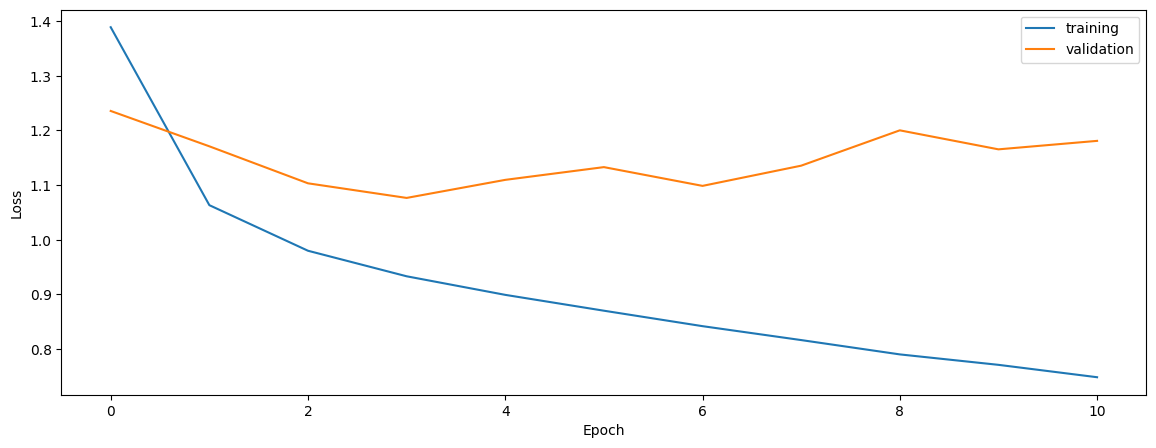

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6406161825883928
0.5839183880915872
0.6130840958908876


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5969366491748422
0.5858433734939759
0.5579163212774312


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5979561251647244
0.5816921553526241
0.5684100814856926


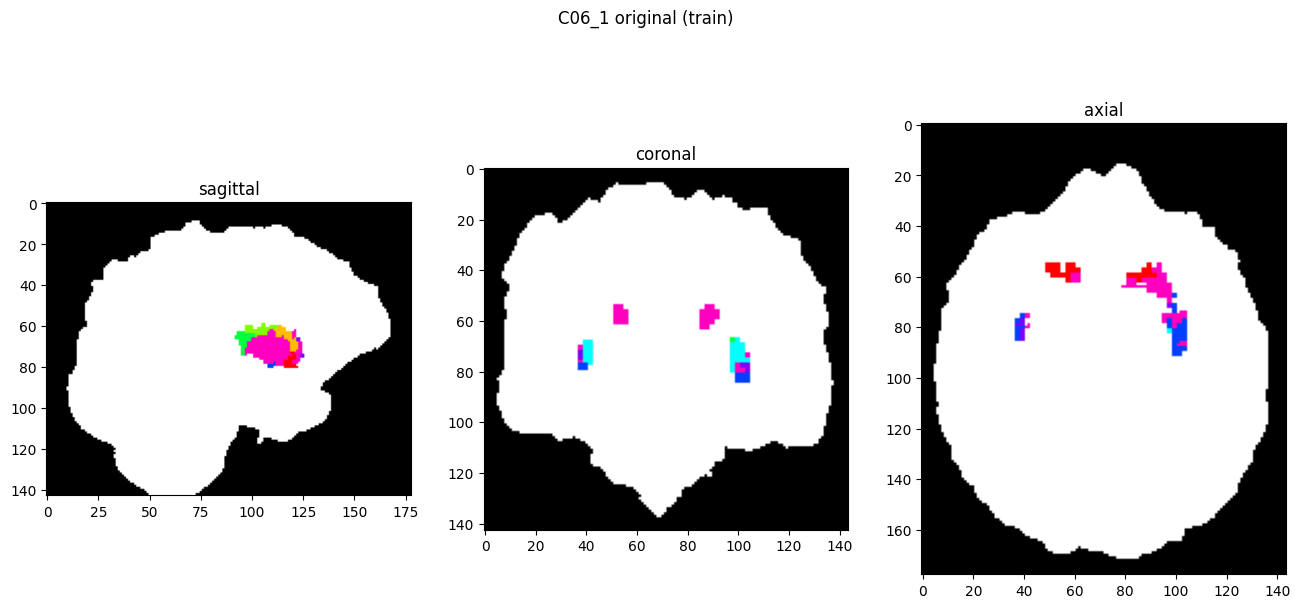

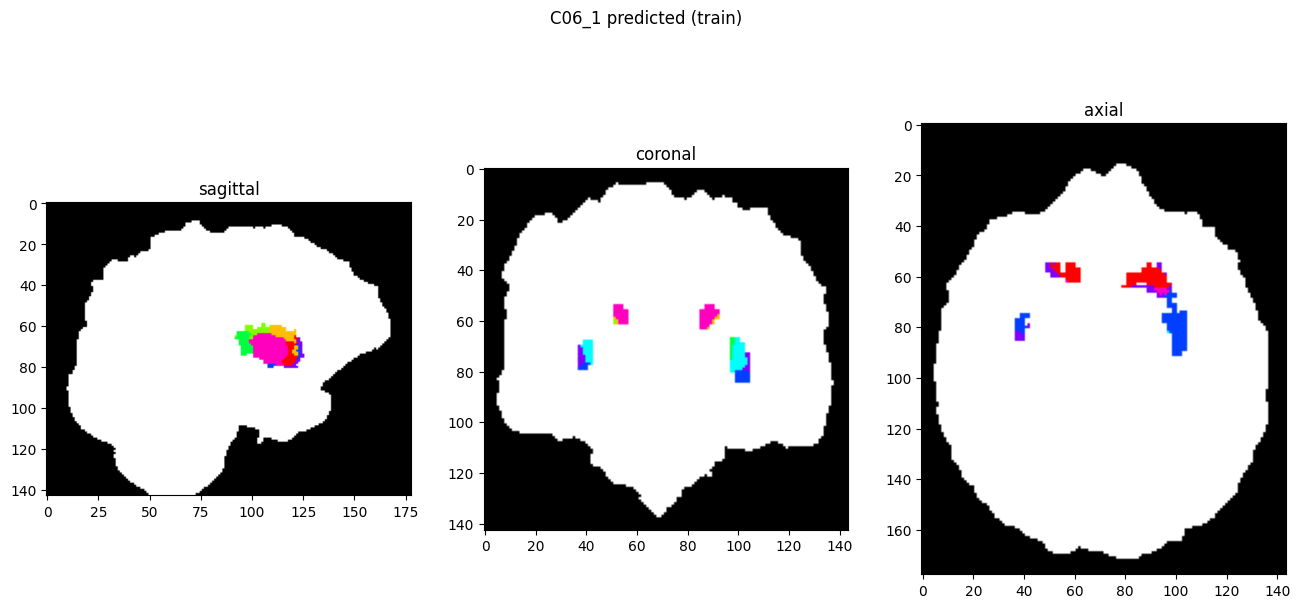

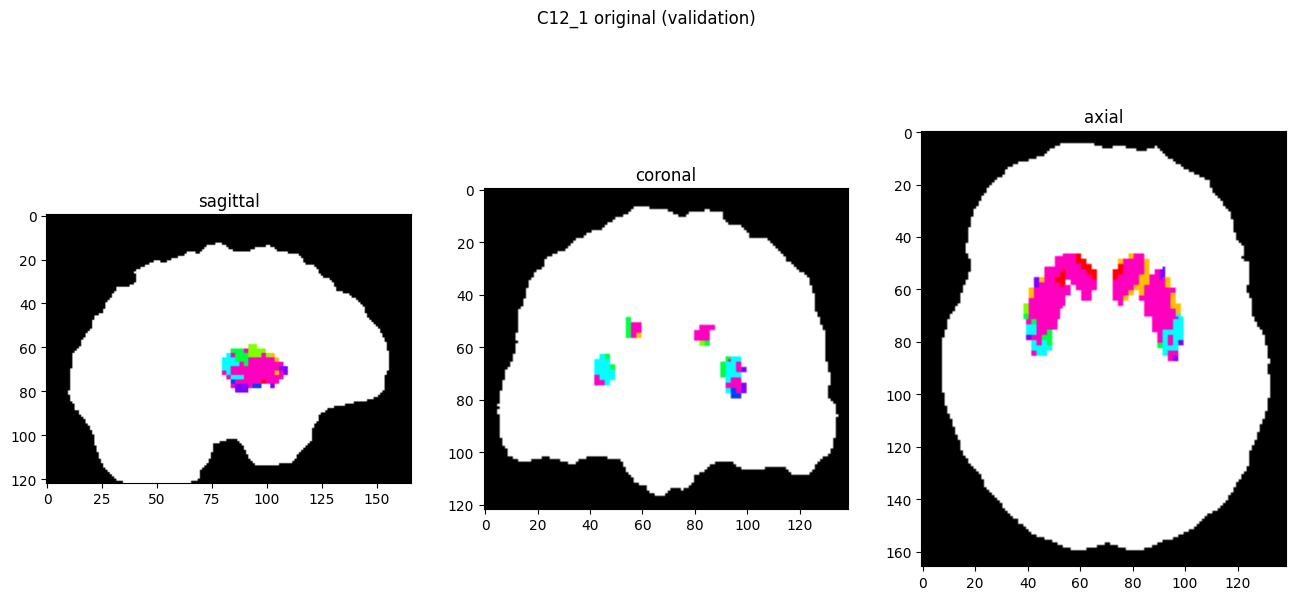

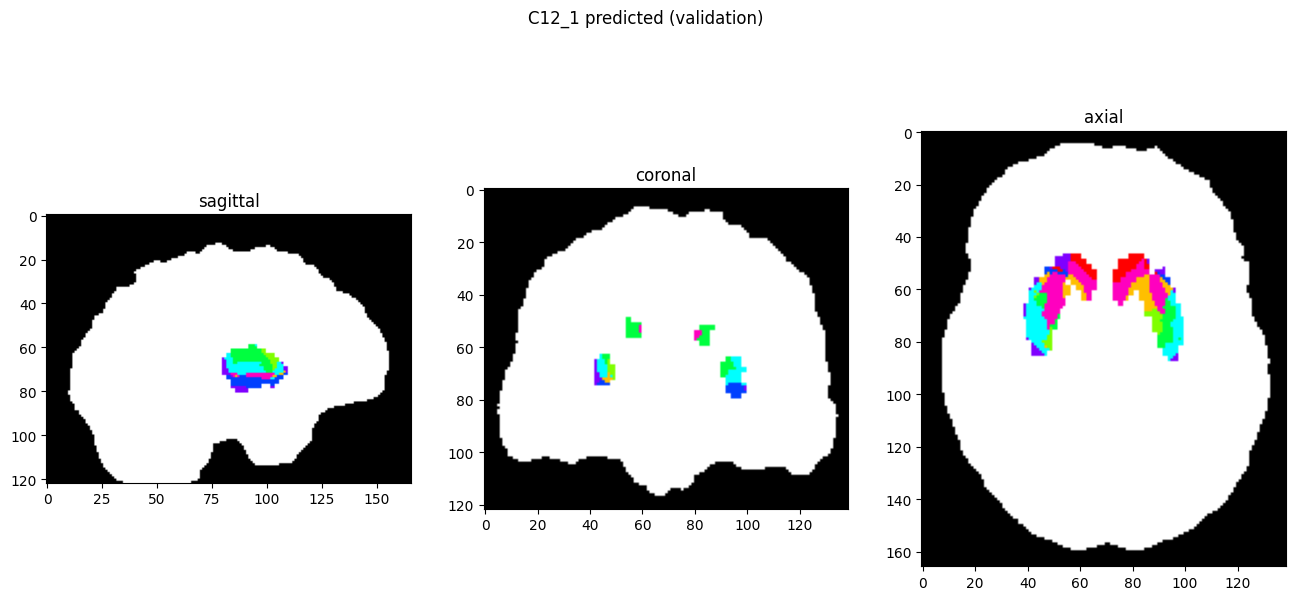

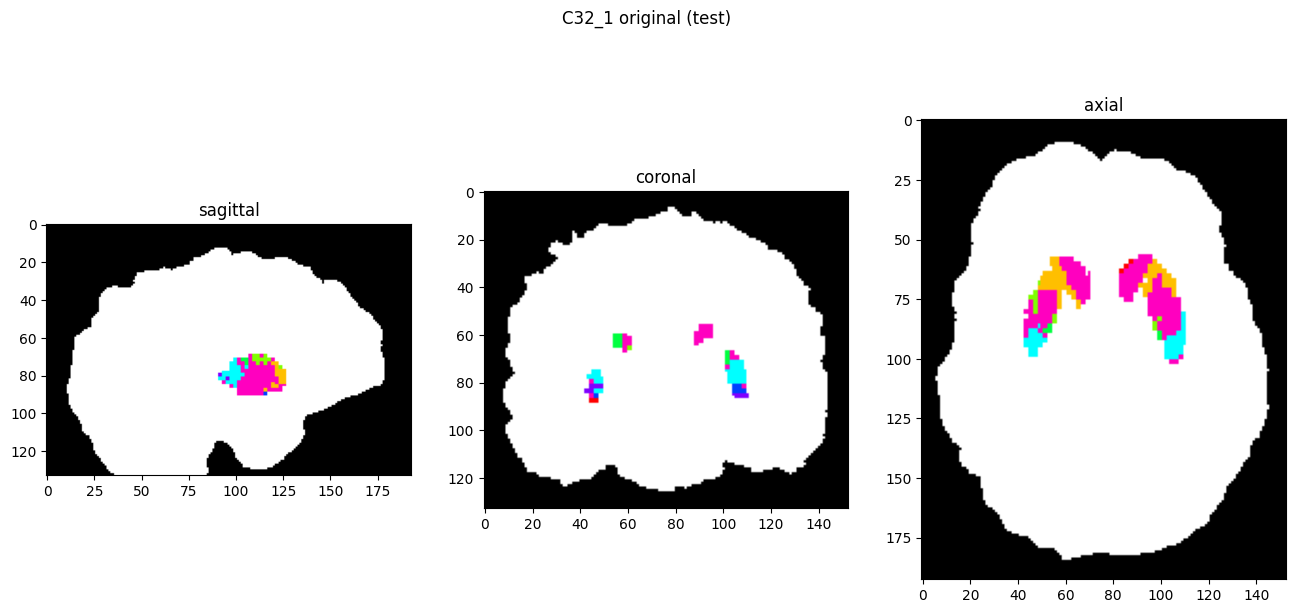

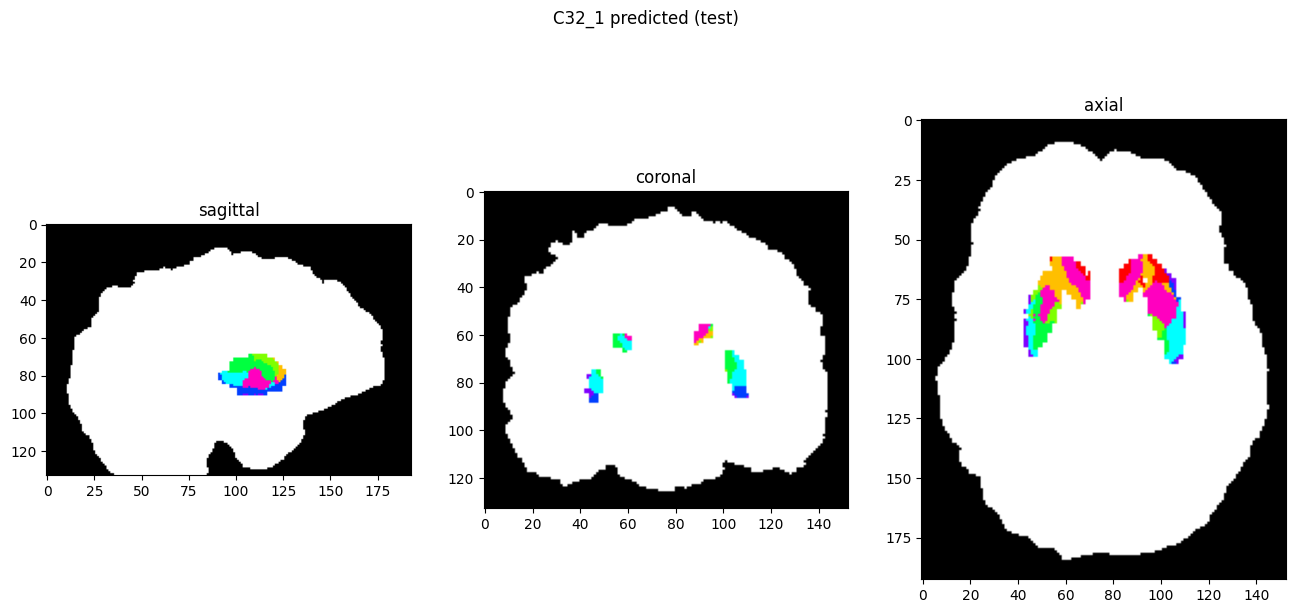

In [10]:
showResults(model, gen, threshold=0)